In [1]:
%matplotlib inline

In [2]:
import pandas as pd
from ydata_profiling import ProfileReport
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV
from yellowbrick.model_selection import FeatureImportances
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
import os
import joblib
from pathlib import Path
import warnings
import scikitplot as skplt

/home/minh48xh/anaconda3/envs/credit/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.1 Import csv file

In [3]:
full_data = pd.read_csv("./datasets/application_record.csv")
credit_data = pd.read_csv("./datasets/credit_record.csv")

In [4]:
full_data

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0       5008804           M            Y               Y             0   
1       5008805           M            Y               Y             0   
2       5008806           M            Y               Y             0   
3       5008808           F            N               Y             0   
4       5008809           F            N               Y             0   
...         ...         ...          ...             ...           ...   
438552  6840104           M            N               Y             0   
438553  6840222           F            N               N             0   
438554  6841878           F            N               N             0   
438555  6842765           F            N               Y             0   
438556  6842885           F            N               Y             0   

        AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0               427500.0               Working               Higher education   
1               427500.0               Working               Higher education   
2               112500.0               Working  Secondary / secondary special   
3               270000.0  Commercial associate  Secondary / secondary special   
4               270000.0  Commercial associate  Secondary / secondary special   
...                  ...                   ...                            ...   
438552          135000.0             Pensioner  Secondary / secondary special   
438553          103500.0               Working  Secondary / secondary special   
438554           54000.0  Commercial associate               Higher education   
438555           72000.0             Pensioner  Secondary / secondary special   
438556          121500.0               Working  Secondary / secondary special   

          NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0             Civil marriage   Rented apartment      -12005          -4542   
1             Civil marriage   Rented apartment      -12005          -4542   
2                    Married  House / apartment      -21474          -1134   
3       Single / not married  House / apartment      -19110          -3051   
4       Single / not married  House / apartment      -19110          -3051   
...                      ...                ...         ...            ...   
438552             Separated  House / apartment      -22717         365243   
438553  Single / not married  House / apartment      -15939          -3007   
438554  Single / not married       With parents       -8169           -372   
438555               Married  House / apartment      -21673         365243   
438556               Married  House / apartment      -18858          -1201   

        FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0                1                1           0           0             NaN   
1                1                1           0           0             NaN   
2                1                0           0           0  Security staff   
3                1                0           1           1     Sales staff   
4                1                0           1           1     Sales staff   
...            ...              ...         ...         ...             ...   
438552           1                0           0           0             NaN   
438553           1                0           0           0        Laborers   
438554           1                1           0           0     Sales staff   
438555           1                0           0           0             NaN   
438556           1                0           1           0     Sales staff   

        CNT_FAM_MEMBERS  
0                   2.0  
1                   2.0  
2                   2.0  
3                   1.0  
4                   1.0  
...                 ...  
438552              1.0  
438553              1.0  
438554              1.0  
43855

In [5]:
credit_data

ID  MONTHS_BALANCE STATUS
0        5001711               0      X
1        5001711              -1      0
2        5001711              -2      0
3        5001711              -3      0
4        5001712               0      C
...          ...             ...    ...
1048570  5150487             -25      C
1048571  5150487             -26      C
1048572  5150487             -27      C
1048573  5150487             -28      C
1048574  5150487             -29      C

[1048575 rows x 3 columns]

### 1.2 Create dataframe an export to csv

In [6]:
pd.options.mode.chained_assignment = None


In [7]:
#Lấy số tháng dư tín dụng (Lấy min do Mothn_balance là số âm)
begin_month = pd.DataFrame(credit_data.groupby("ID")["MONTHS_BALANCE"].min())
begin_month = begin_month.rename(columns={"MONTHS_BALANCE":"Account age"})
#Merge 2 data lại để tổng hợp dữ liệu
full_data = pd.merge(full_data, begin_month, on="ID", how="left")

#Tinsh độ rủi ro của khách hàng
credit_data['Is high risk'] = None
credit_data['Is high risk'][credit_data['STATUS']=="2"] = "Yes"
credit_data['Is high risk'][credit_data['STATUS']=="3"] = "Yes"
credit_data['Is high risk'][credit_data['STATUS']=="4"] = "Yes"
credit_data['Is high risk'][credit_data['STATUS']=="5"] = "Yes"

cpunt = credit_data.groupby("ID").count()
cpunt['Is high risk'][cpunt["Is high risk"] > 0 ]= 1    #Yes
cpunt['Is high risk'][cpunt["Is high risk"] == 0 ]= 0   #No
cpunt = cpunt[["Is high risk"]] ## Chỉ lấy giá trị risk_value

#Merge thêm cột risk_value theo ID
full_data = pd.merge(full_data, cpunt, on="ID", how="inner")


In [8]:
full_data

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0      5008804           M            Y               Y             0   
1      5008805           M            Y               Y             0   
2      5008806           M            Y               Y             0   
3      5008808           F            N               Y             0   
4      5008809           F            N               Y             0   
...        ...         ...          ...             ...           ...   
36452  5149828           M            Y               Y             0   
36453  5149834           F            N               Y             0   
36454  5149838           F            N               Y             0   
36455  5150049           F            N               Y             0   
36456  5150337           M            N               Y             0   

       AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0              427500.0               Working               Higher education   
1              427500.0               Working               Higher education   
2              112500.0               Working  Secondary / secondary special   
3              270000.0  Commercial associate  Secondary / secondary special   
4              270000.0  Commercial associate  Secondary / secondary special   
...                 ...                   ...                            ...   
36452          315000.0               Working  Secondary / secondary special   
36453          157500.0  Commercial associate               Higher education   
36454          157500.0             Pensioner               Higher education   
36455          283500.0               Working  Secondary / secondary special   
36456          112500.0               Working  Secondary / secondary special   

         NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0            Civil marriage   Rented apartment      -12005          -4542   
1            Civil marriage   Rented apartment      -12005          -4542   
2                   Married  House / apartment      -21474          -1134   
3      Single / not married  House / apartment      -19110          -3051   
4      Single / not married  House / apartment      -19110          -3051   
...                     ...                ...         ...            ...   
36452               Married  House / apartment      -17348          -2420   
36453               Married  House / apartment      -12387          -1325   
36454               Married  House / apartment      -12387          -1325   
36455               Married  House / apartment      -17958           -655   
36456  Single / not married   Rented apartment       -9188          -1193   

       FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0               1                1           0           0             NaN   
1               1                1           0           0             NaN   
2               1                0           0           0  Security staff   
3               1                0           1           1     Sales staff   
4               1                0           1           1     Sales staff   
...           ...              ...         ...         ...             ...   
36452           1                0           0           0        Managers   
36453           1                0           1           1  Medicine staff   
36454           1                0           1           1  Medicine staff   
36455           1                0           0           0     Sales staff   
36456           1                0           0           0        Laborers   

       CNT_FAM_MEMBERS  Account age  Is high risk  
0                  2.0        -15.0             0  
1                  2.0        -14.0             0  
2                  2.0        -29.0             0  
3                  1.0         -4.0             0  
4                  1.0        -26.0             0  


### 1.3 Rename features's name

In [9]:
full_data = full_data.rename(columns={
    'CODE_GENDER':'Gender',
    'FLAG_OWN_CAR':'Has a car',
    'FLAG_OWN_REALTY':'Has a property',
    'CNT_CHILDREN':'Children count',
    'AMT_INCOME_TOTAL':'Income',
    'NAME_INCOME_TYPE':'Employment status',
    'NAME_EDUCATION_TYPE':'Education level',
    'NAME_FAMILY_STATUS':'Marital status',
    'NAME_HOUSING_TYPE':'Dwelling',
    'DAYS_BIRTH':'Age',
    'DAYS_EMPLOYED': 'Employment length',
    'FLAG_MOBIL': 'Has a mobile phone',
    'FLAG_WORK_PHONE': 'Has a work phone',
    'FLAG_PHONE': 'Has a phone',
    'FLAG_EMAIL': 'Has an email',
    'OCCUPATION_TYPE': 'Job title',
    'CNT_FAM_MEMBERS': 'Family member count',
    'Account age': 'Account age'
})

full_data

ID Gender Has a car Has a property  Children count    Income  \
0      5008804      M         Y              Y               0  427500.0   
1      5008805      M         Y              Y               0  427500.0   
2      5008806      M         Y              Y               0  112500.0   
3      5008808      F         N              Y               0  270000.0   
4      5008809      F         N              Y               0  270000.0   
...        ...    ...       ...            ...             ...       ...   
36452  5149828      M         Y              Y               0  315000.0   
36453  5149834      F         N              Y               0  157500.0   
36454  5149838      F         N              Y               0  157500.0   
36455  5150049      F         N              Y               0  283500.0   
36456  5150337      M         N              Y               0  112500.0   

          Employment status                Education level  \
0                   Working               Higher education   
1                   Working               Higher education   
2                   Working  Secondary / secondary special   
3      Commercial associate  Secondary / secondary special   
4      Commercial associate  Secondary / secondary special   
...                     ...                            ...   
36452               Working  Secondary / secondary special   
36453  Commercial associate               Higher education   
36454             Pensioner               Higher education   
36455               Working  Secondary / secondary special   
36456               Working  Secondary / secondary special   

             Marital status           Dwelling    Age  Employment length  \
0            Civil marriage   Rented apartment -12005              -4542   
1            Civil marriage   Rented apartment -12005              -4542   
2                   Married  House / apartment -21474              -1134   
3      Single / not married  House / apartment -19110              -3051   
4      Single / not married  House / apartment -19110              -3051   
...                     ...                ...    ...                ...   
36452               Married  House / apartment -17348              -2420   
36453               Married  House / apartment -12387              -1325   
36454               Married  House / apartment -12387              -1325   
36455               Married  House / apartment -17958               -655   
36456  Single / not married   Rented apartment  -9188              -1193   

       Has a mobile phone  Has a work phone  Has a phone  Has an email  \
0                       1                 1            0             0   
1                       1                 1            0             0   
2                       1                 0            0             0   
3                       1                 0            1             1   
4                       1                 0            1             1   
...                   ...               ...          ...           ...   
36452                   1                 0            0             0   
36453                   1                 0            1             1   
36454                   1                 0            1             1   
36455                   1                 0            0             0   
36456                   1                 0            0             0   

            Job title  Family member count  Account age  Is high risk  
0                 NaN                  2.0        -15.0             0  
1                 NaN                  2.0        -14.0             0  
2      Security staff                  2.0        -29.0             0  
3         Sales staff                  1.0         -4.0             0  
4         Sales staff                  1.0        -26.0             0  
...               ...                  ...          ...           ...  
36452        Managers                  2.0      

### 1.4 Split the data into training and test, create a copy of the dataset

In [10]:
def split_data(df, test_size):
    train_df, test_df = train_test_split(df, test_size= test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [11]:
train_original, test_original = split_data(full_data, 0.2)

In [12]:
train_original.shape

(29165, 20)

In [13]:
test_original.shape

(7292, 20)

In [14]:
train_original.to_csv("./datasets/train.csv", index=False)
test_original.to_csv("./datasets/test.csv", index=False)

In [15]:
train_copy = train_original.copy()
test_copy = test_original.copy()

## 2. Expore the data

### 2.0 Pandas profiting

In [16]:
#EDA dữ liệu thành file html
# profile_report = ProfileReport(full_data,dark_mode= True)
# profile_report.to_file("./pandas_profile_file/credit_pred_profile.html")

### 2.1 Quick show data

In [17]:
full_data.head()

ID Gender Has a car Has a property  Children count    Income  \
0  5008804      M         Y              Y               0  427500.0   
1  5008805      M         Y              Y               0  427500.0   
2  5008806      M         Y              Y               0  112500.0   
3  5008808      F         N              Y               0  270000.0   
4  5008809      F         N              Y               0  270000.0   

      Employment status                Education level        Marital status  \
0               Working               Higher education        Civil marriage   
1               Working               Higher education        Civil marriage   
2               Working  Secondary / secondary special               Married   
3  Commercial associate  Secondary / secondary special  Single / not married   
4  Commercial associate  Secondary / secondary special  Single / not married   

            Dwelling    Age  Employment length  Has a mobile phone  \
0   Rented apartment -12005              -4542                   1   
1   Rented apartment -12005              -4542                   1   
2  House / apartment -21474              -1134                   1   
3  House / apartment -19110              -3051                   1   
4  House / apartment -19110              -3051                   1   

   Has a work phone  Has a phone  Has an email       Job title  \
0                 1            0             0             NaN   
1                 1            0             0             NaN   
2                 0            0             0  Security staff   
3                 0            1             1     Sales staff   
4                 0            1             1     Sales staff   

   Family member count  Account age  Is high risk  
0                  2.0        -15.0             0  
1                  2.0        -14.0             0  
2                  2.0        -29.0             0  
3                  1.0         -4.0             0  
4                  1.0        -26.0             0

In [18]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   Gender               36457 non-null  object 
 2   Has a car            36457 non-null  object 
 3   Has a property       36457 non-null  object 
 4   Children count       36457 non-null  int64  
 5   Income               36457 non-null  float64
 6   Employment status    36457 non-null  object 
 7   Education level      36457 non-null  object 
 8   Marital status       36457 non-null  object 
 9   Dwelling             36457 non-null  object 
 10  Age                  36457 non-null  int64  
 11  Employment length    36457 non-null  int64  
 12  Has a mobile phone   36457 non-null  int64  
 13  Has a work phone     36457 non-null  int64  
 14  Has a phone          36457 non-null  int64  
 15  Has an email         36457 non-null 

In [19]:
full_data.describe()

ID  Children count        Income           Age  \
count  3.645700e+04    36457.000000  3.645700e+04  36457.000000   
mean   5.078227e+06        0.430315  1.866857e+05 -15975.173382   
std    4.187524e+04        0.742367  1.017892e+05   4200.549944   
min    5.008804e+06        0.000000  2.700000e+04 -25152.000000   
25%    5.042028e+06        0.000000  1.215000e+05 -19438.000000   
50%    5.074614e+06        0.000000  1.575000e+05 -15563.000000   
75%    5.115396e+06        1.000000  2.250000e+05 -12462.000000   
max    5.150487e+06       19.000000  1.575000e+06  -7489.000000   

       Employment length  Has a mobile phone  Has a work phone   Has a phone  \
count       36457.000000             36457.0      36457.000000  36457.000000   
mean        59262.935568                 1.0          0.225526      0.294813   
std        137651.334859                 0.0          0.417934      0.455965   
min        -15713.000000                 1.0          0.000000      0.000000   
25%         -3153.000000                 1.0          0.000000      0.000000   
50%         -1552.000000                 1.0          0.000000      0.000000   
75%          -408.000000                 1.0          0.000000      1.000000   
max        365243.000000                 1.0          1.000000      1.000000   

       Has an email  Family member count   Account age  Is high risk  
count  36457.000000         36457.000000  36457.000000  36457.000000  
mean       0.089722             2.198453    -26.164193      0.016897  
std        0.285787             0.911686     16.501854      0.128886  
min        0.000000             1.000000    -60.000000      0.000000  
25%        0.000000             2.000000    -39.000000      0.000000  
50%        0.000000             2.000000    -24.000000      0.000000  
75%        0.000000             3.000000    -12.000000      0.000000  
max        1.000000            20.000000      0.000000      1.000000

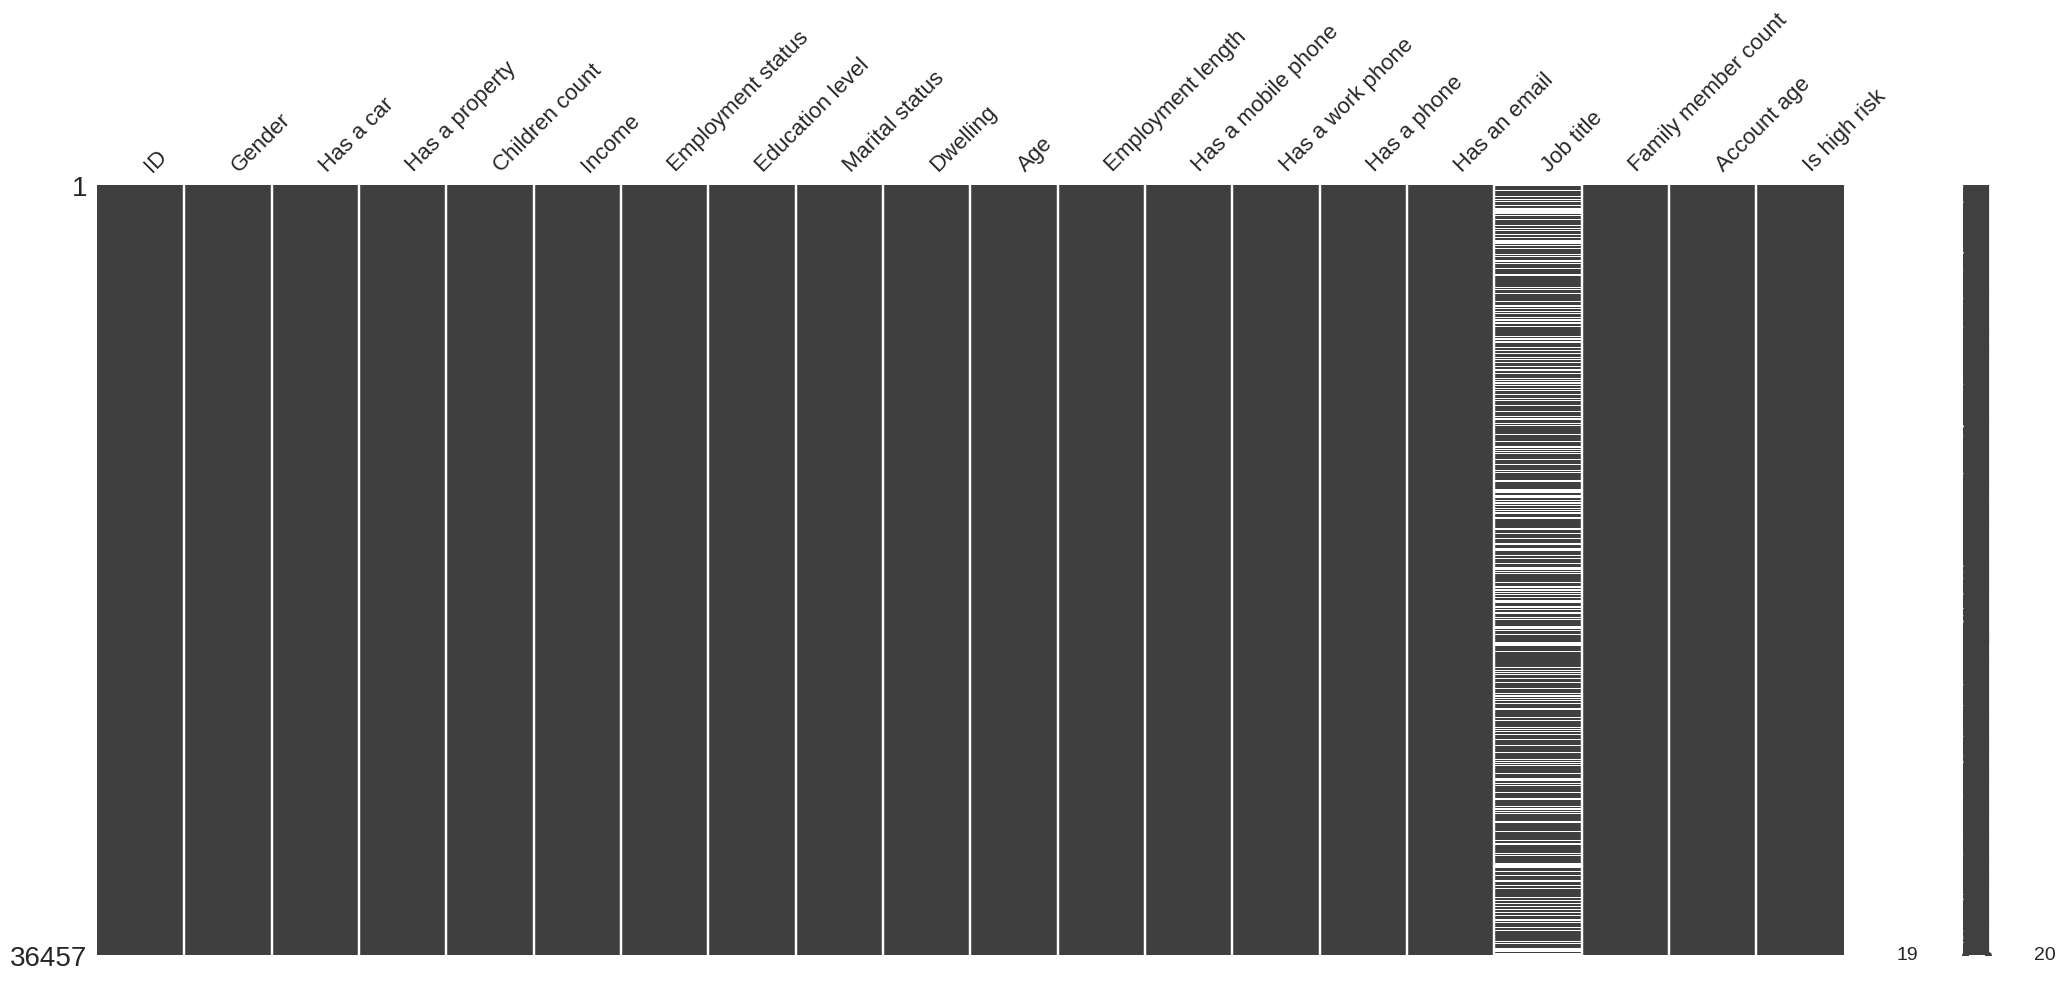

In [20]:
msno.matrix(full_data)
plt.show()

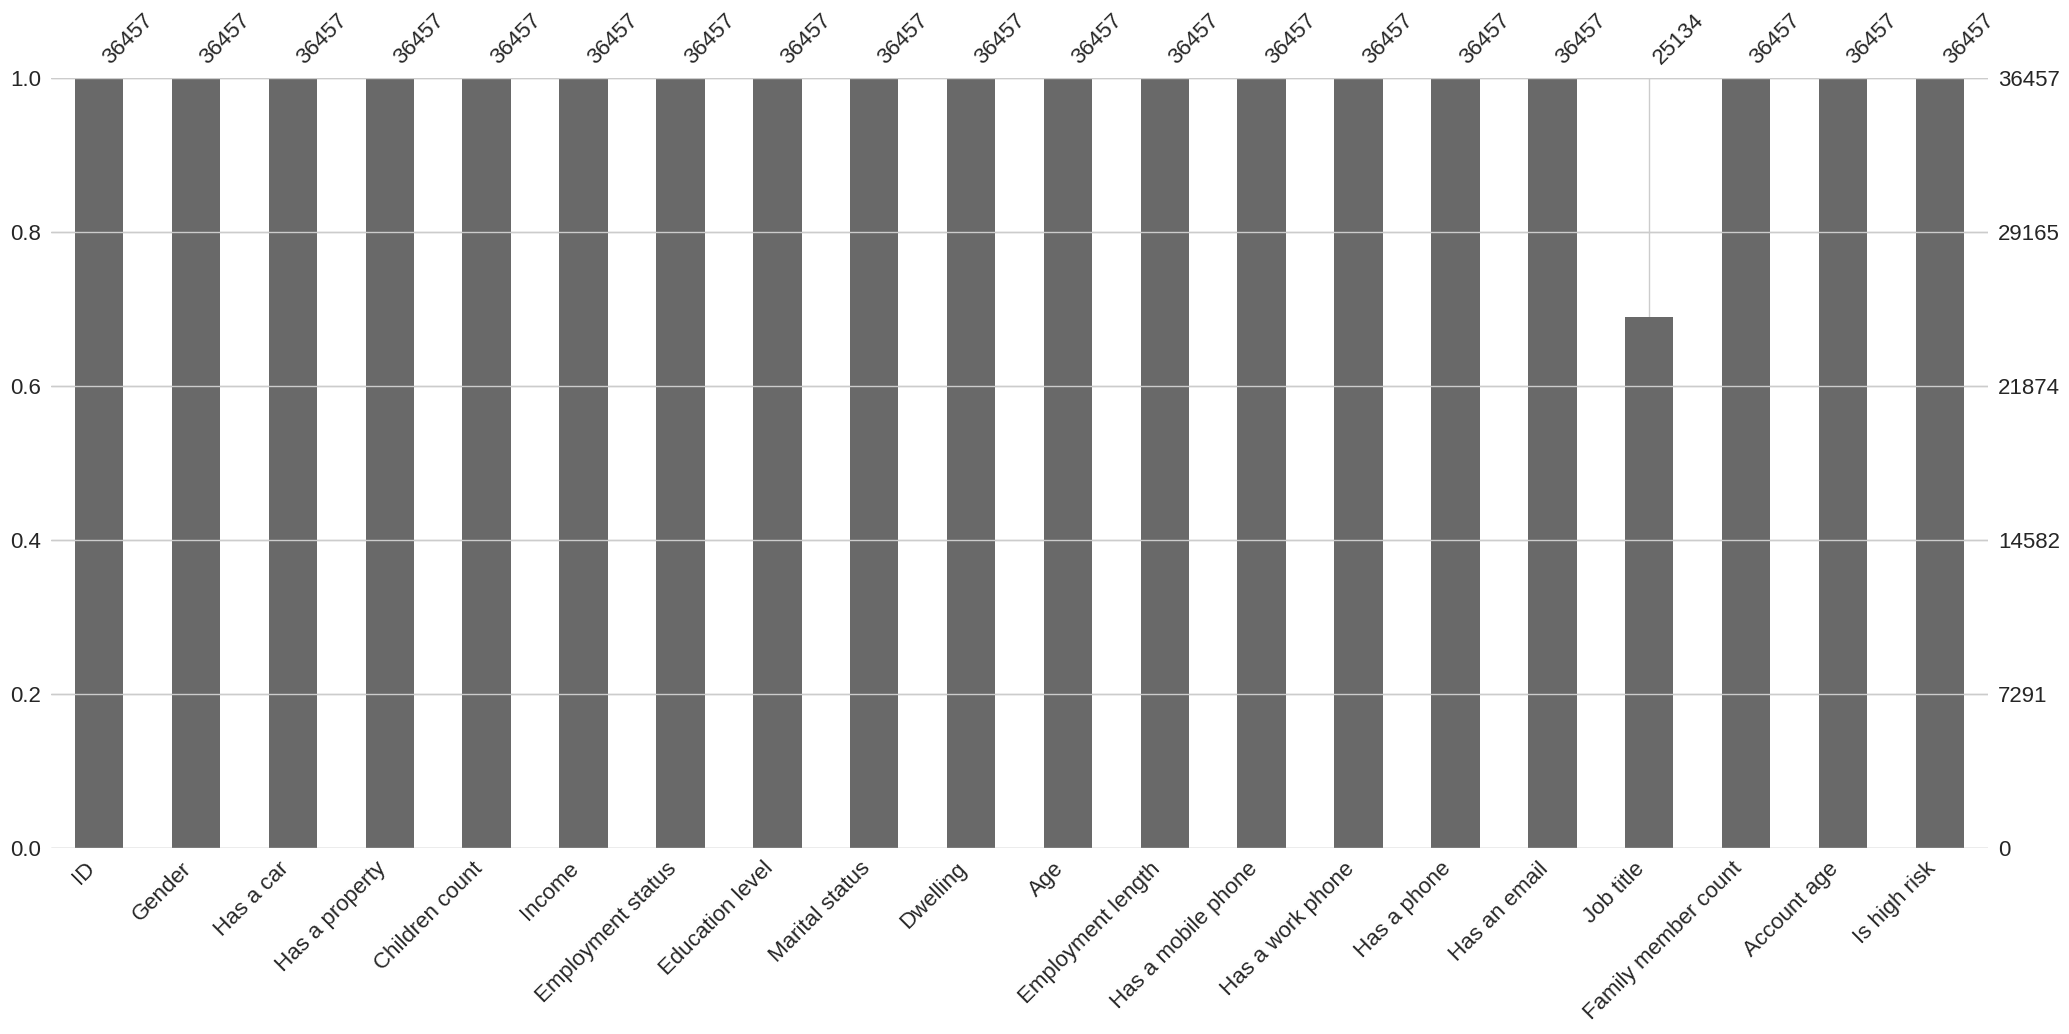

In [21]:
msno.bar(full_data)
plt.show()

<i>Nhận xét: </i>Cột Job title là cột thiếu rất nhiều dữ liệu

### 2.2 Functions used to visualize

In [22]:
# Hàm trả về số lượng và % xuất hiện
def  value_count_norm_cal(df, feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

In [23]:
# Hàm trả về dữ liệu tổng quan
def get_info_feat(df,feature):
    match feature:
        case 'Age':
            # Chuyển Age từ dạng ngày sang thành dạng năm (365.25 là tổng số ngày trên năm có năm nhuận)
            print('Description:\n{}'.format((np.abs(df[feature])/365.25).describe()))
            print('*'*50)
            print('Object type:{}'.format(df[feature].dtype))
        case 'Employment length':
            # Chỉ trọn những người có thời gian âm còn lại bỏ qua những người đã nghỉ việc và thất nghiệp
            employment_len_no_ret = df['Employment length'][df['Employment length'] < 0]
            employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
            print('Description:\n{}'.format((employment_len_no_ret_yrs).describe()))
            print('*'*50)
            print('Object type:{}'.format(employment_len_no_ret.dtype))
        case 'Account age':
            # Đổi account age từ số âm thành số dương
            print('Description:\n{}'.format((np.abs(df[feature])).describe()))
            print('*'*50)
            print('Object type:{}'.format(df[feature].dtype))
        case _:
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            value_cnt = value_count_norm_cal(df,feature)
            print('Value count:\n{}'.format(value_cnt))

In [24]:
# Hàm trả về biểu đồ pie plot
def create_pie_plot(df,feature):
    match feature:
        case 'Dwelling' | 'Education level':
            ratio_size = value_count_norm_cal(df, feature)
            ratio_size_len = len(ratio_size.index)
            ratio_list = []
            for i in range(ratio_size_len):
                ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
            fig, ax = plt.subplots(figsize=(8,8))
            # %1.2f%% hiển thị pie chart và số 2 số sau chữ số thập phân
            plt.pie(ratio_list, startangle=90, wedgeprops={'edgecolor' :'black'})
            plt.title('Pie chart of {}'.format(feature))
            plt.legend(loc='best',labels=ratio_size.index)
            plt.axis('equal')
            return plt.show()
        case _:
            ratio_size = value_count_norm_cal(df, feature)
            ratio_size_len = len(ratio_size.index)
            ratio_list = []
            for i in range(ratio_size_len):
                ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
            fig, ax = plt.subplots(figsize=(8,8))
            # %1.2f%% hiển thị pie chart và số 2 số sau chữ số thập phân
            plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor' :'black'})
            plt.title('Pie chart of {}'.format(feature))
            plt.legend(loc='best')
            plt.axis('equal')
            return plt.show()

In [25]:
# function to create a bar chart plot
def create_bar_plot(df,feature):
    match feature:
        case 'Marital status' | 'Dwelling' | 'Job title' | 'Employment status' | 'Education level':
            fig, ax = plt.subplots(figsize=(6,10))
            sns.barplot(x=value_count_norm_cal(df,feature).index,y=value_count_norm_cal(df,feature).values[:,0])
            ax.set_xticklabels(labels=value_count_norm_cal(df,feature).index,rotation=45,ha='right')
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.title('{} count'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(6,10))
            sns.barplot(x=value_count_norm_cal(df,feature).index,y=value_count_norm_cal(df,feature).values[:,0])
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.title('{} count'.format(feature))
            return plt.show()

In [26]:
# Hàm trả về biểu đồ box-plot
def create_box_plot(df,feature):
    match feature:
        case 'Age':
            fig, ax = plt.subplots(figsize=(2,8))
            # Đổi từ số ngày sang số năm
            sns.boxplot(y=np.abs(df[feature])/365.25)
            plt.title('{} distribution(Boxplot)'.format(feature))
            return plt.show()
        case 'Children count':
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature])
            plt.title('{} distribution(Boxplot)'.format(feature))
            plt.yticks(np.arange(0,df[feature].max(),1))
            return plt.show()
        case 'Employment length':
            fig, ax = plt.subplots(figsize=(2,8))
            employment_len_no_ret = df['Employment length'][df['Employment length'] < 0]
            # employement length là số âm nên lấy trị tuyệt đối và đổi ra ngày
            employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
            sns.boxplot(y=employment_len_no_ret_yrs)
            plt.title('{} distribution(Boxplot)'.format(feature))
            plt.yticks(np.arange(0,employment_len_no_ret_yrs.max(),2))
            return plt.show()
        case 'Income':
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature])
            plt.title('{} distribution(Boxplot)'.format(feature))
            # Loại bỏ ký hiệu đặc biệt
            ax.get_yaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            return plt.show()
        case 'Account age':
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=np.abs(df[feature]))
            plt.title('{} distribution(Boxplot)'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature])
            plt.title('{} distribution(Boxplot)'.format(feature))
            return plt.show()

In [27]:
# Hàm vẽ biểu đồ histogram
def create_hist_plot(df,feature, the_bins=50):
    match feature:
        case 'Age':
            fig, ax = plt.subplots(figsize=(18,10))
            # Đổi Age thành số tuổi
            sns.histplot(np.abs(df[feature])/365.25,bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case 'Income':
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(df[feature],bins=the_bins,kde=True)
            # Loại bỏ các ký hiệu đặc biệt
            ax.get_xaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case 'Employment length':
            employment_len_no_ret = df['Employment length'][df['Employment length'] < 0]
            # employement length là số âm nên lấy trị tuyệt đối và đổi ra ngày
            employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(employment_len_no_ret_yrs,bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case 'Account age':
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(np.abs(df[feature]),bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(df[feature],bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()

In [28]:
# High risk vs low risk applicants compared on a box plot
def low_high_risk_box_plot(df,feature):
    match feature:
        case 'Age':
            print(np.abs(df.groupby('Is high risk')[feature].mean()/365.25))
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=np.abs(df[feature])/365.25,x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title('High risk individuals grouped by age')
            return plt.show()
        case 'Income':
            print(np.abs(df.groupby('Is high risk')[feature].mean()))
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            # suppress scientific notation
            ax.get_yaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            plt.title('High risk individuals grouped by {}'.format(feature))
            return plt.show()
        case 'Employment length':
            #checking is an applicant is high risk or not (for those who have negative employment length aka the employed ones)
            employment_no_ret = df['Employment length'][df['Employment length'] <0]
            employment_no_ret_idx = employment_no_ret.index
            employment_len_no_ret_yrs = np.abs(employment_no_ret)/365.25
            employment_no_ret_df = df.iloc[employment_no_ret_idx][['Employment length','Is high risk']]
            employment_no_ret_is_high_risk = employment_no_ret_df.groupby('Is high risk')['Employment length'].mean()
            # compare the age of high risk individuals with the age of low risk individuals (those who are employed)
            print(np.abs(employment_no_ret_is_high_risk)/365.25)
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=employment_len_no_ret_yrs,x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title('High vs low risk individuals grouped by {}'.format(feature))
            return plt.show()
        case _:
            print(np.abs(df.groupby('Is high risk')[feature].mean()))
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title('High risk individuals grouped by {}'.format(feature))
            return plt.show()

In [29]:
# So sánh high risk vs low risk với feature bằng biểu đồ box-plot
def low_high_risk_bar_plot(df,feature):
    is_high_risk_grp = df.groupby(feature)['Is high risk'].sum()
    is_high_risk_grp_srt = is_high_risk_grp.sort_values(ascending=False)
    print(dict(is_high_risk_grp_srt))
    fig, ax = plt.subplots(figsize=(6,10))
    sns.barplot(x=is_high_risk_grp_srt.index,y=is_high_risk_grp_srt.values)
    ax.set_xticklabels(labels=is_high_risk_grp_srt.index,rotation=45, ha='right')
    plt.ylabel('Count')
    plt.title('High risk applicants count grouped by {}'.format(feature))
    return plt.show()

### 2.3 Phân tích đơn biến

#### 2.3.1 Gender

In [30]:
get_info_feat(full_data, "Gender")

Description:
count     36457
unique        2
top           F
freq      24430
Name: Gender, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
F  24430      67.010451
M  12027      32.989549


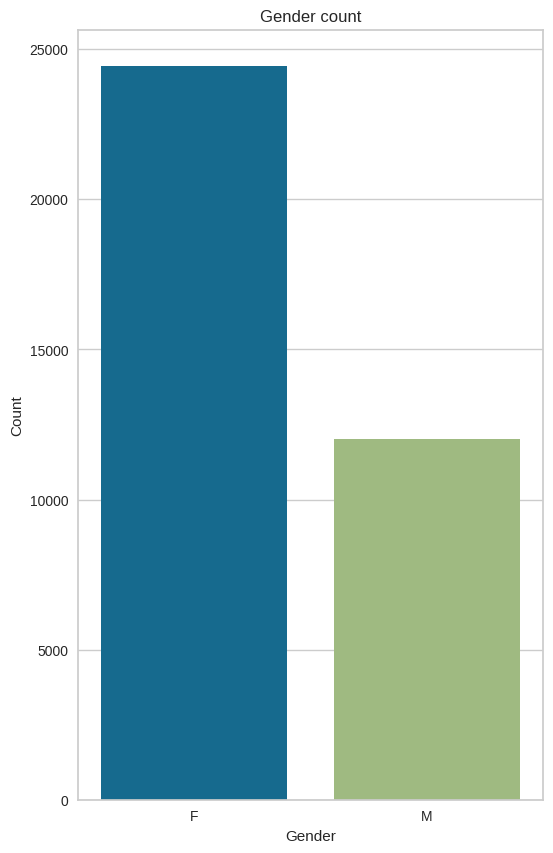

In [31]:
create_bar_plot(full_data, "Gender")

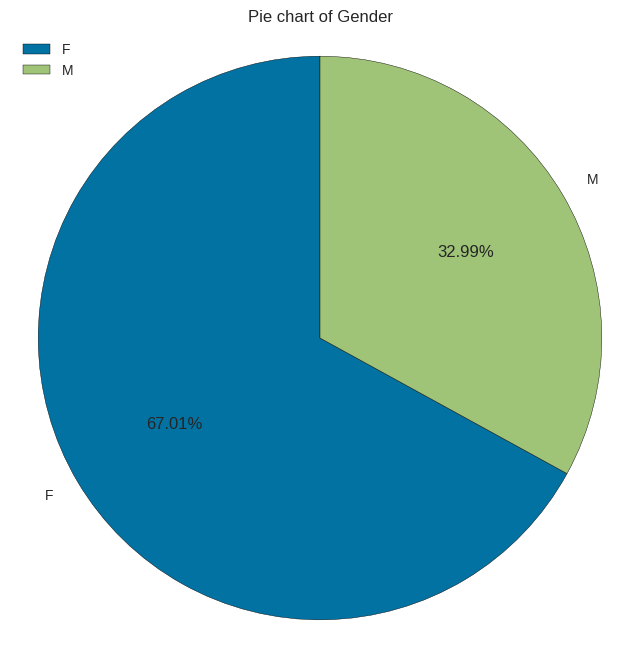

In [32]:
create_pie_plot(full_data, "Gender")

Nhận xét:
- Ta thấy Female chiếm nhiều Male(67% vs 33%)

#### 2.3.2 Age

In [33]:
get_info_feat(full_data, "Age")

Description:
count    36457.000000
mean        43.737641
std         11.500479
min         20.503765
25%         34.119097
50%         42.609172
75%         53.218344
max         68.862423
Name: Age, dtype: float64
**************************************************
Object type:int64


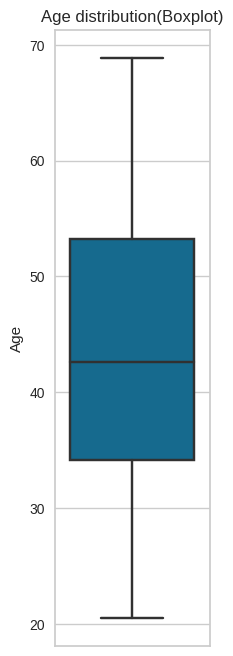

In [34]:
create_box_plot(full_data, "Age")

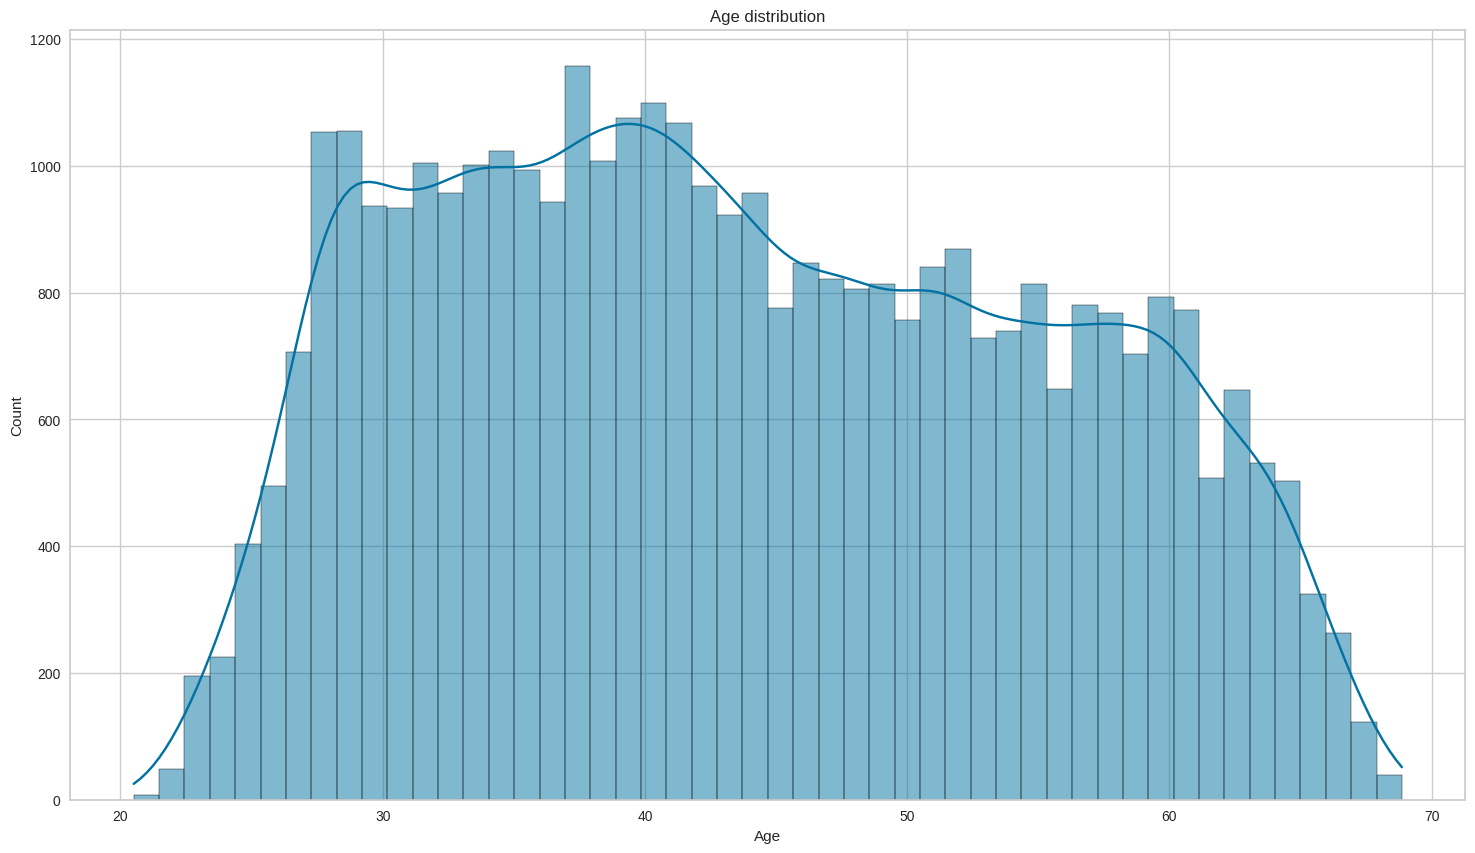

In [35]:
create_hist_plot(full_data, "Age")

Is high risk
0    43.739870
1    43.607954
Name: Age, dtype: float64


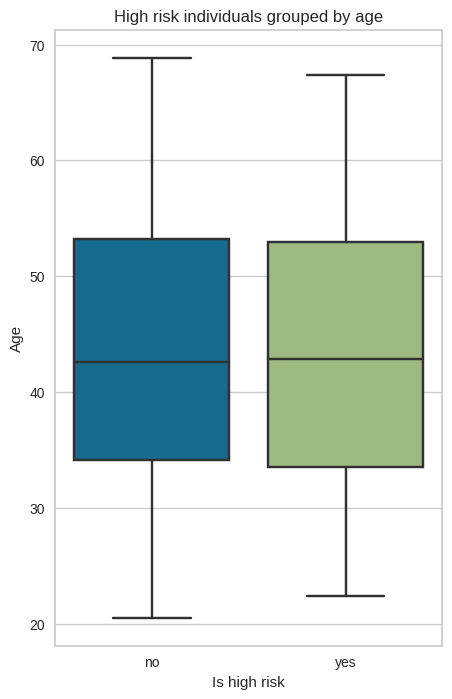

In [36]:
low_high_risk_box_plot(full_data, "Age")

Nhận xét:
- Người có độ tuổi trẻ nhất là 21 tuổi và già nhất có tuổi là 69 tuổi
- Trung bình độ tuổi là 43 tuổi
- Từ biểu đồ thấy,  phân bố độ tuổi phân phối không bình thường và có xu hướng hơi lệch trái
- Từ biểu đồ box-plot ta thấy nhóm high risk và low risk không có sự khác nhau về mặt độ tuổi

#### 2.3.2 Marital status (Tình trạng hôn nhân)

In [37]:
get_info_feat(full_data, "Marital status")

Description:
count       36457
unique          5
top       Married
freq        25048
Name: Marital status, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                      Count  Frequency (%)
Married               25048      68.705598
Single / not married   4829      13.245742
Civil marriage         2945       8.078010
Separated              2103       5.768440
Widow                  1532       4.202211


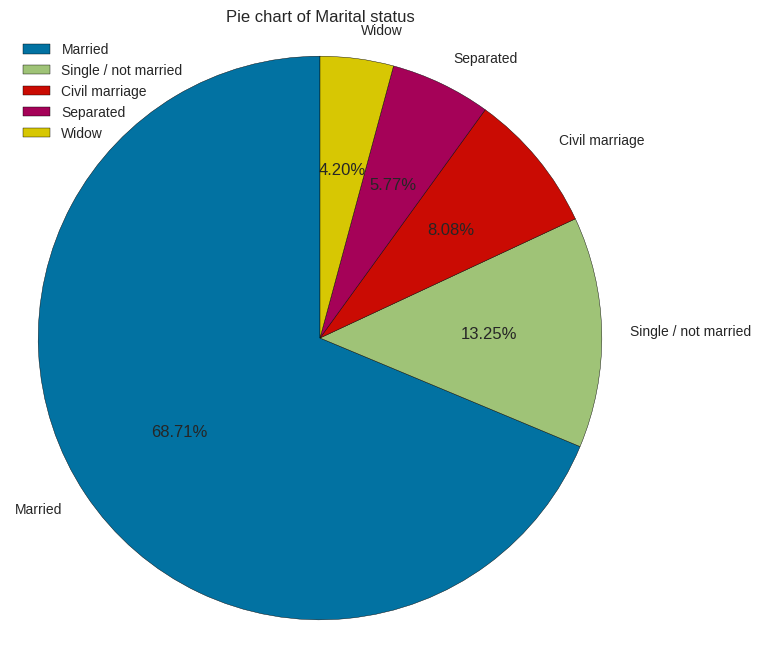

In [38]:
create_pie_plot(full_data, "Marital status")

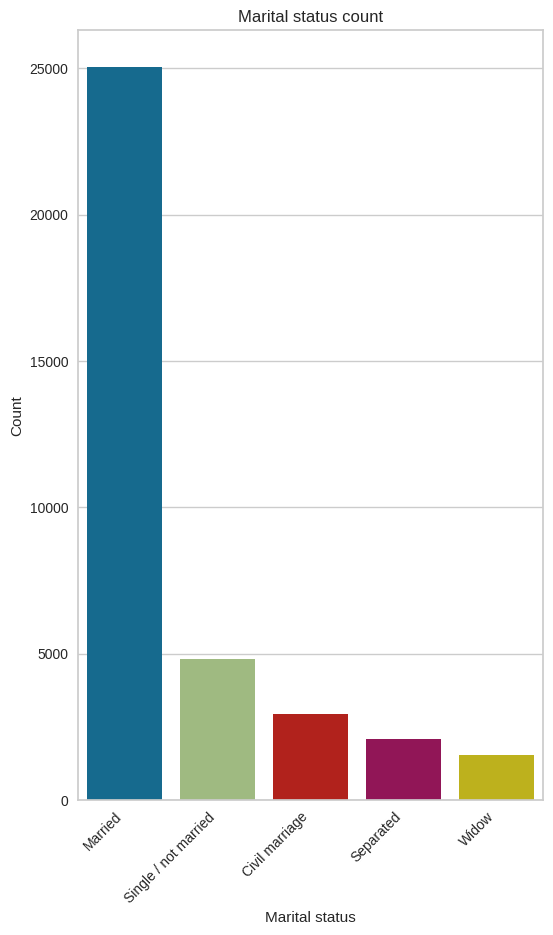

In [39]:
create_bar_plot(full_data, "Marital status")

{'Married': 393, 'Single / not married': 101, 'Civil marriage': 46, 'Widow': 45, 'Separated': 31}


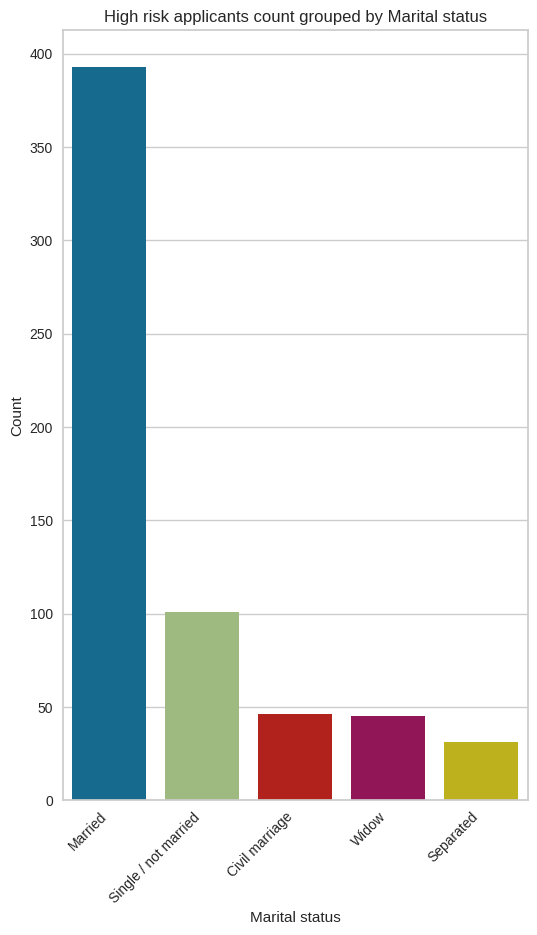

In [40]:
low_high_risk_bar_plot(full_data, "Marital status")

Nhận xét:
- Tình trạng hôn nhân đã kết hôn chiếm chủ yếu 70% sau đố là độc thân/ chưa kết hôn chiếm 13%
- So sánh khi gom nhóm high risk ta thấy không có sự tách biệt lắm giữa các tình trạng hôn nhân

#### 2.3.4 Family count

In [41]:
get_info_feat(full_data, "Family member count")

Description:
count    36457.000000
mean         2.198453
std          0.911686
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         20.000000
Name: Family member count, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
      Count  Frequency (%)
2.0   19463      53.386181
1.0    6987      19.165044
3.0    6421      17.612530
4.0    3106       8.519626
5.0     397       1.088954
6.0      58       0.159092
7.0      19       0.052116
15.0      3       0.008229
9.0       2       0.005486
20.0      1       0.002743


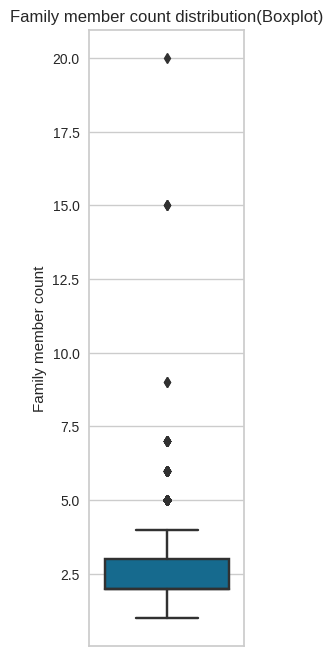

In [42]:
create_box_plot(full_data, "Family member count")

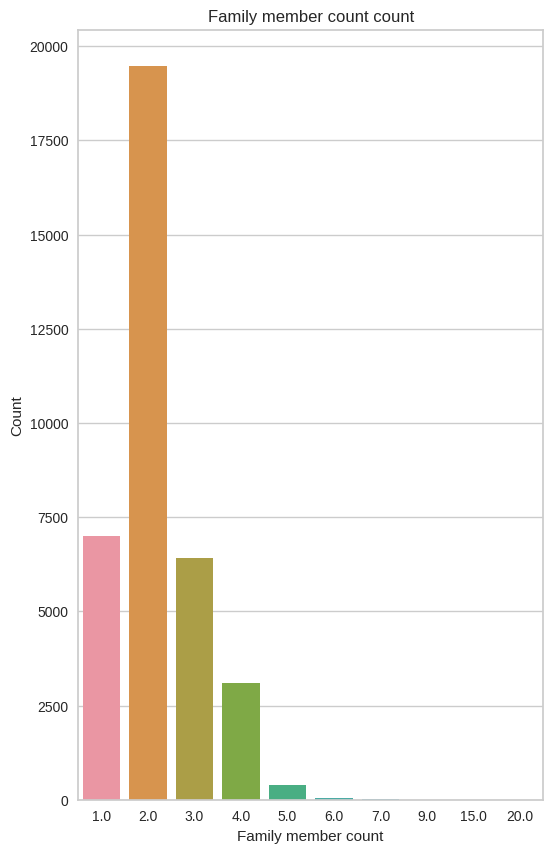

In [43]:
create_bar_plot(full_data, "Family member count")

Nhận xét:
- Từ biểu đồ bar chart ta thấy gia đình thường có 2 người tức là tập trung chủ yếu ở gia đình chưa có con
- Từ biểu đồ box plot ta cũng thấy có 6 outlier rất lớn như có 15 - 20 người trong một hộ gia đình

#### 2.3.5 Chilren count

In [44]:
get_info_feat(full_data, "Children count")

Description:
count    36457.000000
mean         0.430315
std          0.742367
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         19.000000
Name: Children count, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
    Count  Frequency (%)
0   25201      69.125271
1    7492      20.550237
2    3256       8.931069
3     419       1.149299
4      63       0.172806
5      20       0.054859
14      3       0.008229
7       2       0.005486
19      1       0.002743


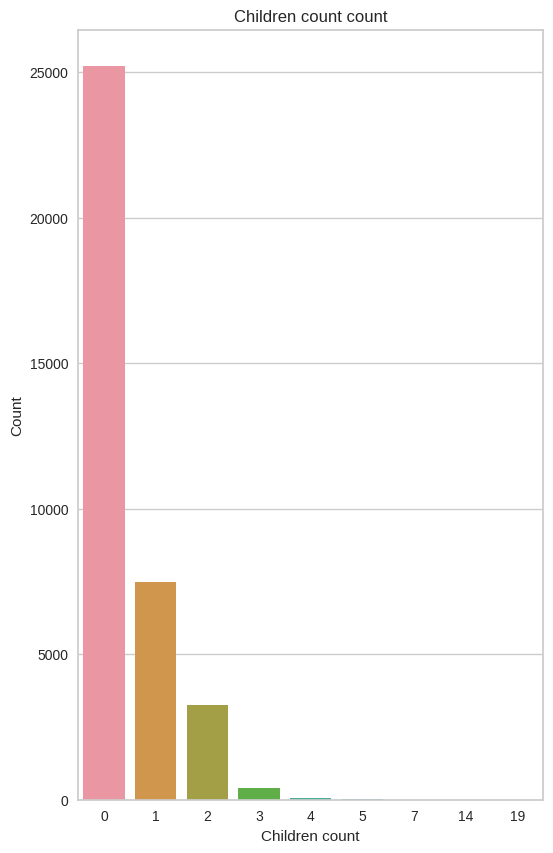

In [45]:
create_bar_plot(full_data, "Children count")

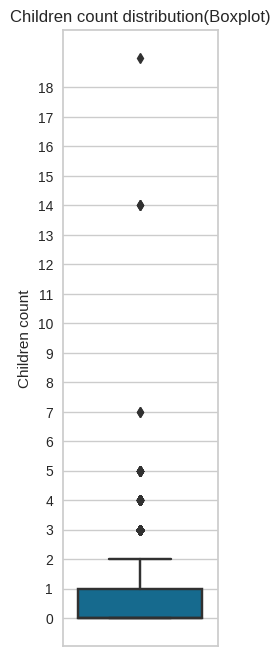

In [46]:
create_box_plot(full_data, "Children count")

{0: 431, 1: 120, 2: 52, 3: 12, 4: 1, 5: 0, 7: 0, 14: 0, 19: 0}


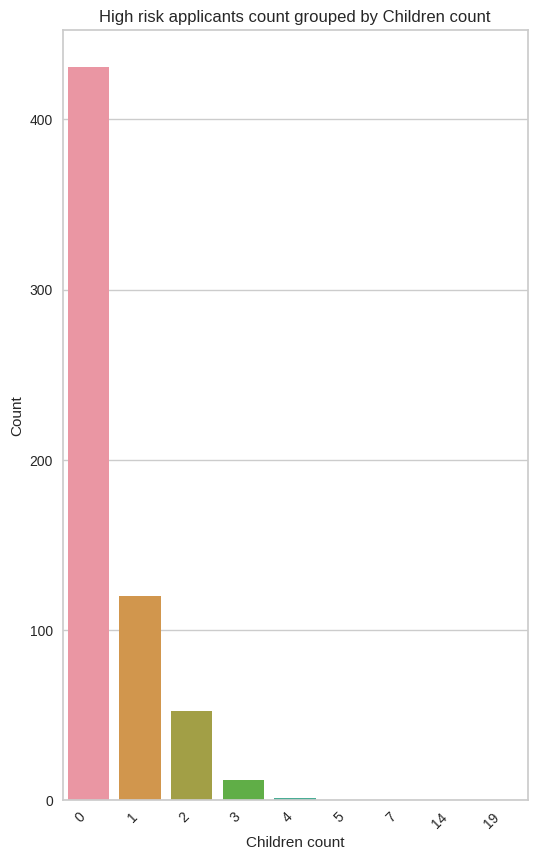

In [47]:
low_high_risk_bar_plot(full_data, "Children count")

Nhận xét
- Các hộ gia đình có xu hướng không có con hoặc có 1 con
- Tương tự như phần số lượng thành viên trong gia đình ta vẫn có 6 outlier

#### 2.3.6 Drewling type (Loại nhà ở)

In [48]:
get_info_feat(full_data, "Dwelling")

Description:
count                 36457
unique                    6
top       House / apartment
freq                  32548
Name: Dwelling, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                     Count  Frequency (%)
House / apartment    32548      89.277779
With parents          1776       4.871492
Municipal apartment   1128       3.094056
Rented apartment       575       1.577201
Office apartment       262       0.718655
Co-op apartment        168       0.460817


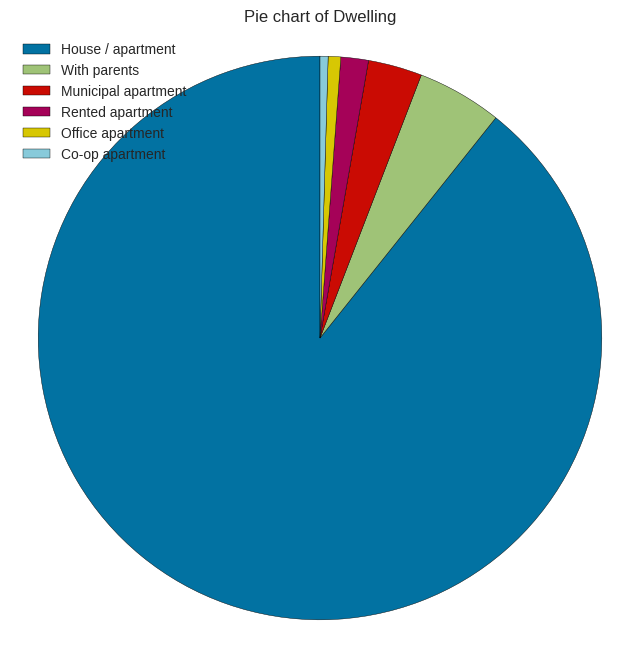

In [49]:
create_pie_plot(full_data, "Dwelling")

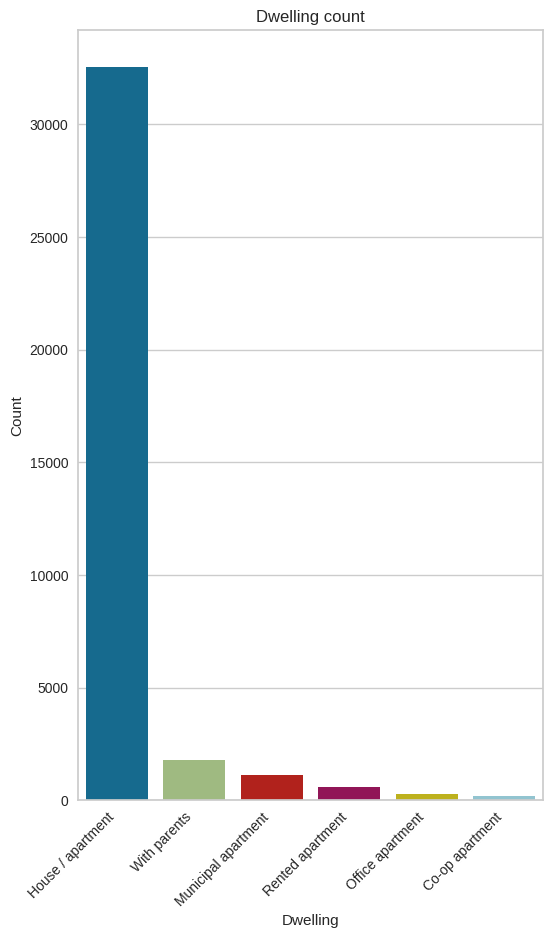

In [50]:
create_bar_plot(full_data, "Dwelling")

Nhận xét:
- Loại cư trú chiếm đa số là nhà/ căn hộ

#### 2.3.7 Income(Thu nhập)

In [51]:
get_info_feat(full_data, "Income")

Description:
count    3.645700e+04
mean     1.866857e+05
std      1.017892e+05
min      2.700000e+04
25%      1.215000e+05
50%      1.575000e+05
75%      2.250000e+05
max      1.575000e+06
Name: Income, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
          Count  Frequency (%)
135000.0   4309      11.819404
180000.0   3097       8.494939
157500.0   3089       8.472996
112500.0   2956       8.108182
225000.0   2926       8.025894
...         ...            ...
177750.0      1       0.002743
594000.0      1       0.002743
164250.0      1       0.002743
124200.0      1       0.002743
179271.0      1       0.002743

[265 rows x 2 columns]


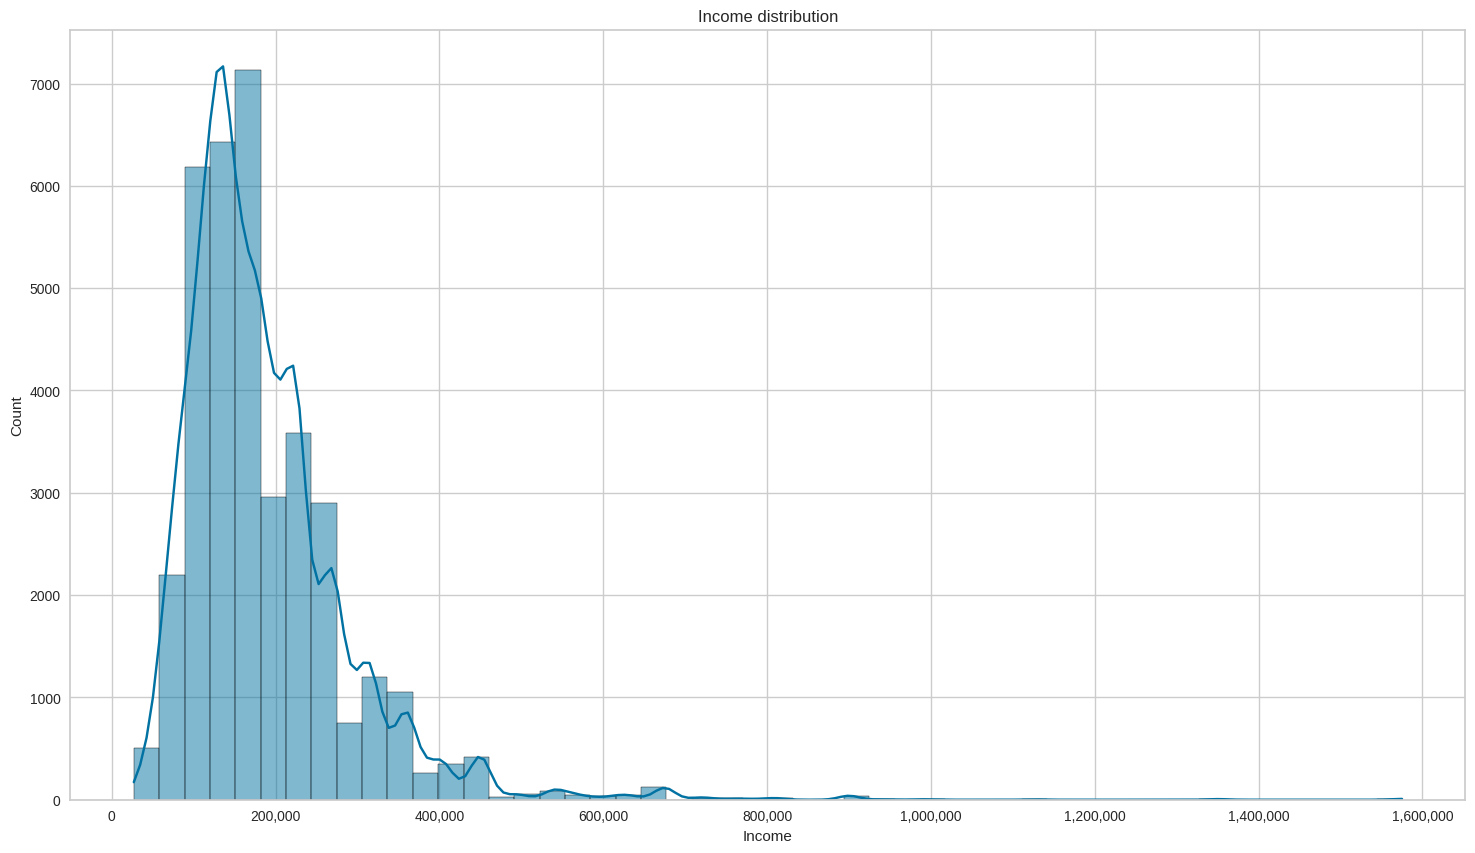

In [52]:
create_hist_plot(full_data, "Income")

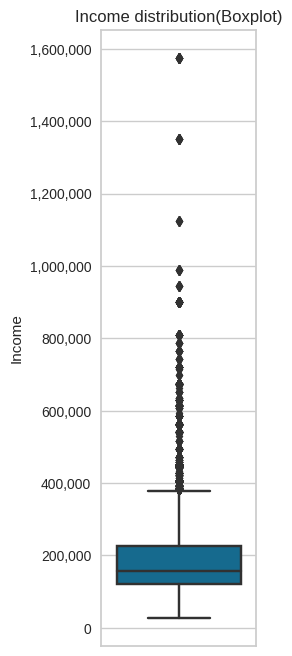

In [53]:
create_box_plot(full_data, "Income")

Is high risk
0    186699.846740
1    185864.763799
Name: Income, dtype: float64


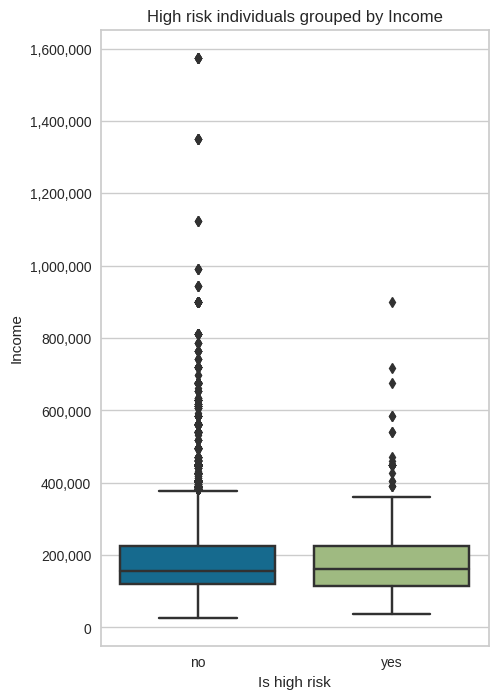

In [54]:
low_high_risk_box_plot(full_data, "Income")

Nhận xét:
- Không có sự khác nhau giữ high risk và low risk giữa các nhóm thu nhập khác nhau
- Phân bố thu nhập có xu hướng lệch bên trái
- Có 3 ứng viên thu nhập trên 1.000.000

#### 2.3.8 Job title

In [55]:
get_info_feat(full_data, "Job title")

Description:
count        25134
unique          18
top       Laborers
freq          6211
Name: Job title, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                       Count  Frequency (%)
Laborers                6211      24.711546
Core staff              3591      14.287419
Sales staff             3485      13.865680
Managers                3012      11.983767
Drivers                 2138       8.506406
High skill tech staff   1383       5.502507
Accountants             1241       4.937535
Medicine staff          1207       4.802260
Cooking staff            655       2.606032
Security staff           592       2.355375
Cleaning staff           551       2.192250
Private service staff    344       1.368664
Low-skill Laborers       175       0.696268
Waiters/barmen staff     174       0.692289
Secretaries              151       0.600780
HR staff                  85       0.3381

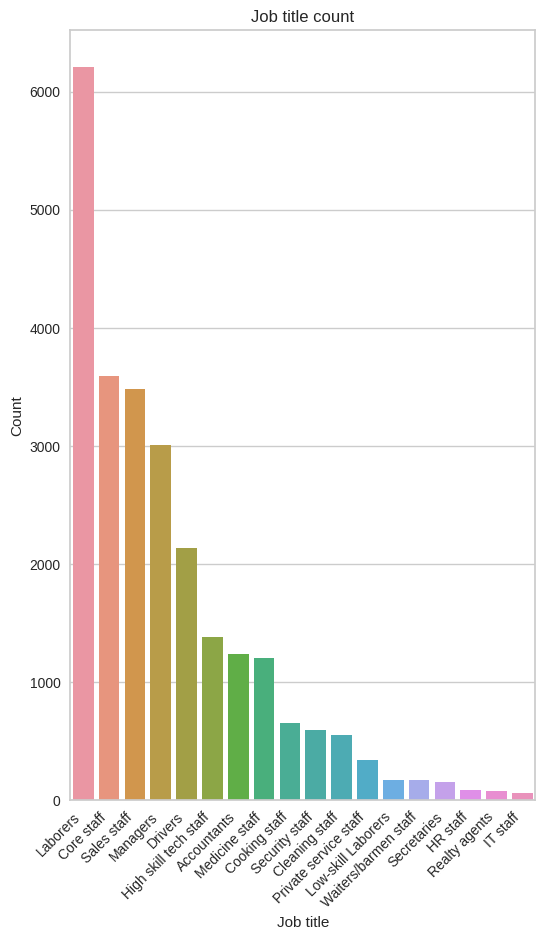

In [56]:
create_bar_plot(full_data, "Job title")

Nhận xét:
- Chủ yếu nghề nghiệp là người lao động (Laborers)
- Dữ liệu bị thiếu rất nhiều

#### 2.3.9 Employment status

In [57]:
get_info_feat(full_data, "Employment status")

Description:
count       36457
unique          5
top       Working
freq        18819
Name: Employment status, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                      Count  Frequency (%)
Working               18819      51.619716
Commercial associate   8490      23.287709
Pensioner              6152      16.874674
State servant          2985       8.187728
Student                  11       0.030173


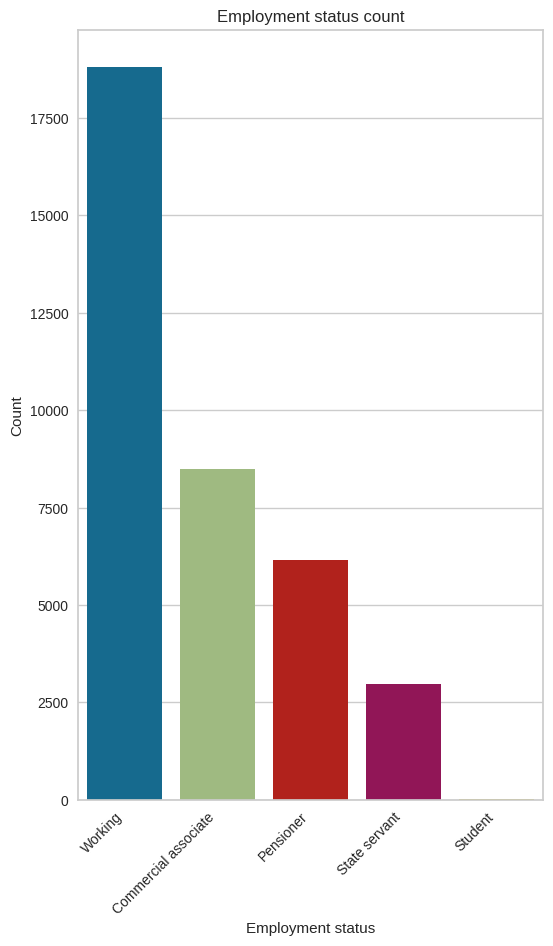

In [58]:
create_bar_plot(full_data, "Employment status")

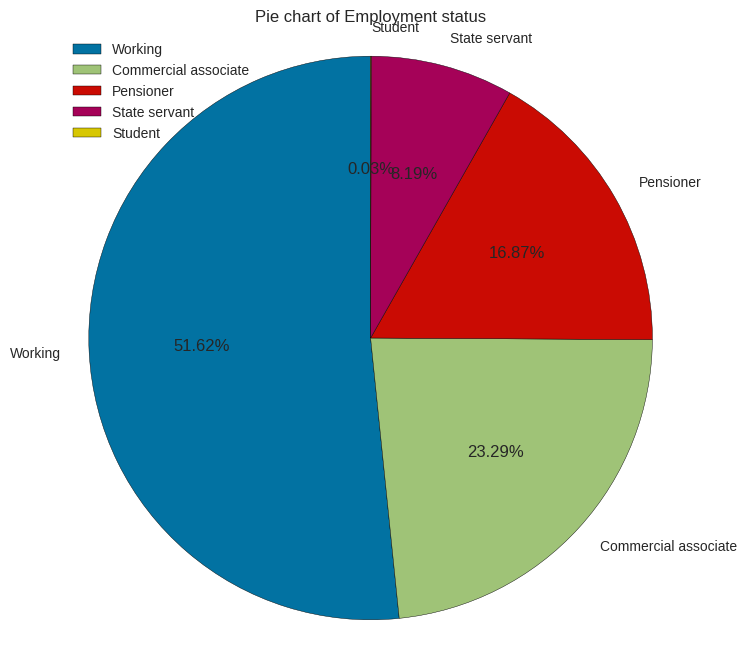

In [59]:
create_pie_plot(full_data, "Employment status")

Nhận xét:
- Đa số khách hàng là người đi làm

#### 2.3.10 Education level

In [60]:
get_info_feat(full_data, "Education level")

Description:
count                             36457
unique                                5
top       Secondary / secondary special
freq                              24777
Name: Education level, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                               Count  Frequency (%)
Secondary / secondary special  24777      67.962257
Higher education                9864      27.056532
Incomplete higher               1410       3.867570
Lower secondary                  374       1.025866
Academic degree                   32       0.087775


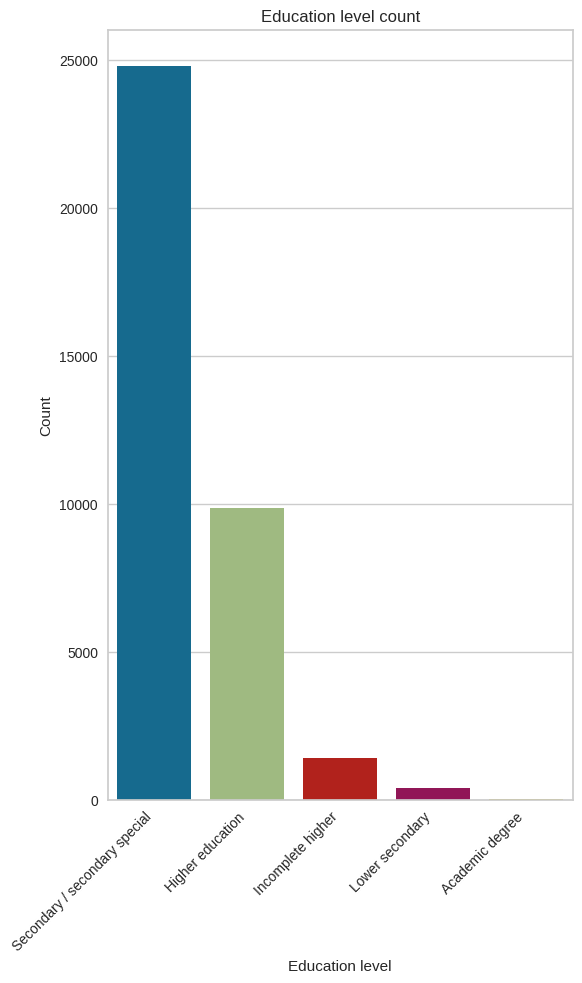

In [61]:
create_bar_plot(full_data, "Education level")

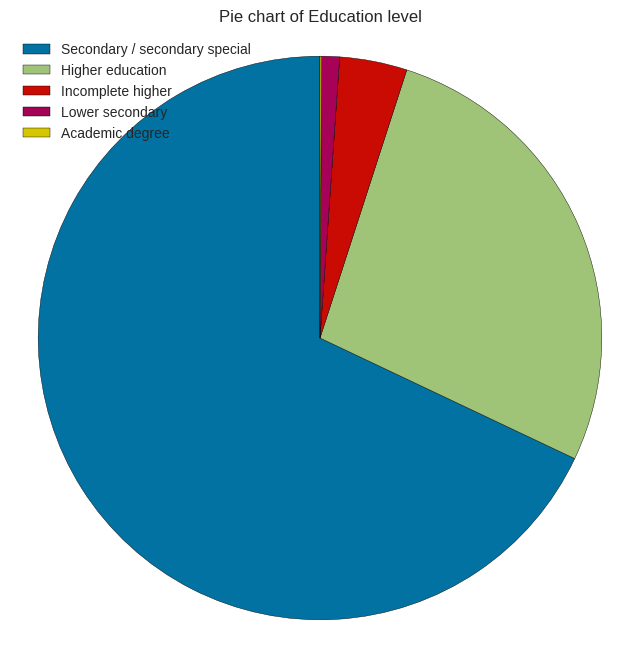

In [62]:
create_pie_plot(full_data, "Education level")

{'Secondary / secondary special': 402, 'Higher education': 171, 'Incomplete higher': 33, 'Lower secondary': 10, 'Academic degree': 0}


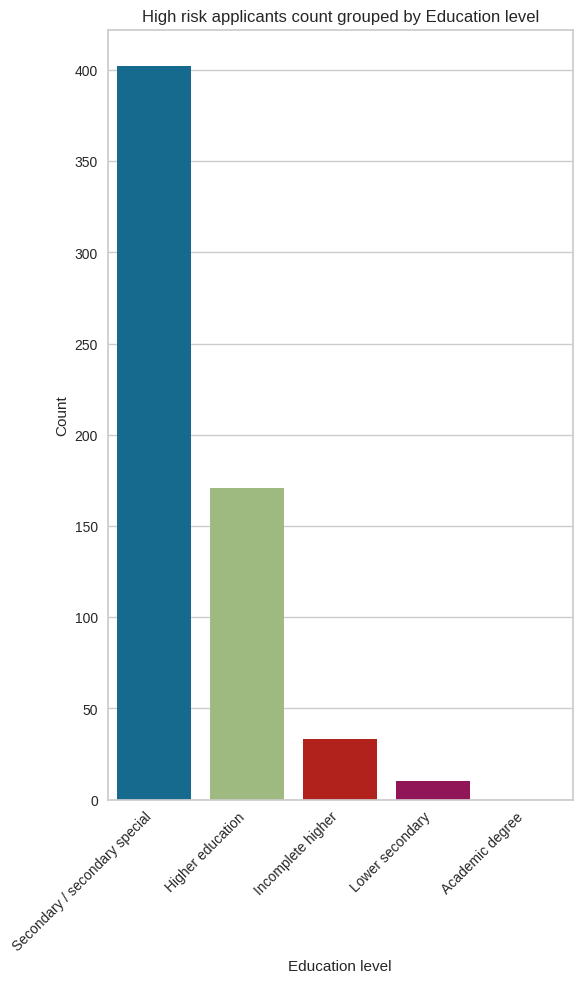

In [63]:
low_high_risk_bar_plot(full_data, "Education level")

Nhận xét:
- Đa số khách hàng đều tốt nghiệp trung học cơ sở và 1/4 trong đó là hoàn thành chương trình đại học

#### 2.3.1 Employment length

In [64]:
get_info_feat(full_data, "Employment length")

Description:
count    30322.000000
mean         7.242994
std          6.454230
min          0.046543
25%          2.677618
50%          5.453799
75%          9.596167
max         43.019849
Name: Employment length, dtype: float64
**************************************************
Object type:int64


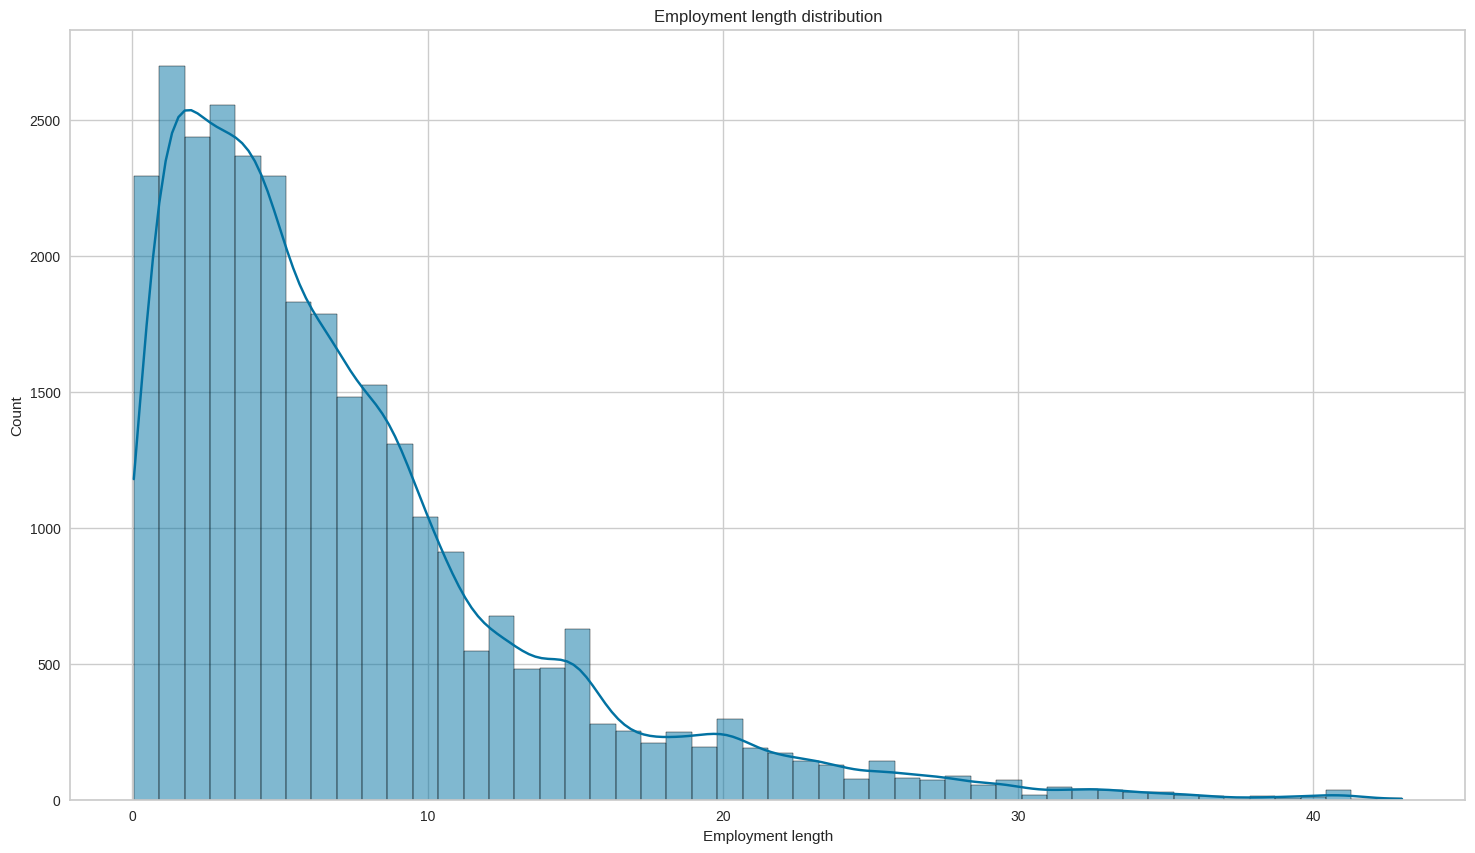

In [65]:
create_hist_plot(full_data, "Employment length")

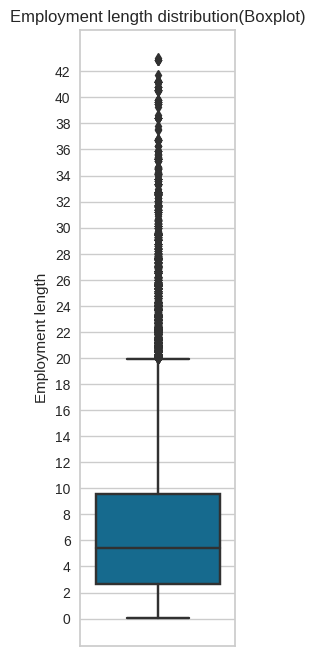

In [66]:
create_box_plot(full_data,"Employment length" )

Is high risk
0    7.263873
1    6.005277
Name: Employment length, dtype: float64


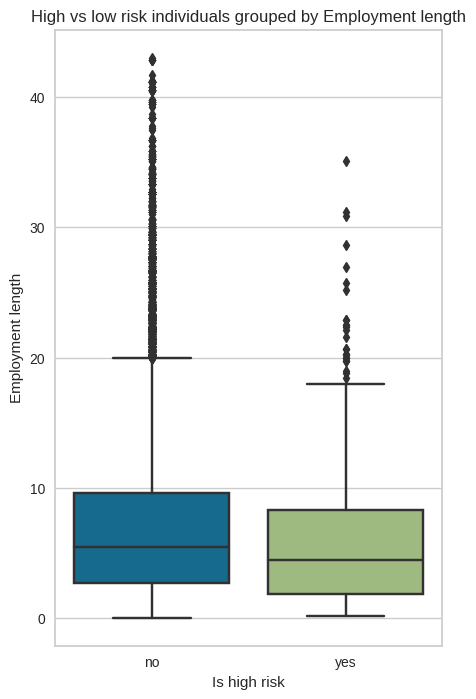

In [67]:
low_high_risk_box_plot(full_data, "Employment length")

Nhận xét:
- Đa số thời gian làm việc trong khoảng 5-7 năm.
- Ta thấy rất nhiều outlier làm việc > 20 năm.
- Phân phối thời gian làm việc rơi có thiên hướng lệch trái nhiều.
- Nhóm rủi ro cao có xu hướng có thời gian làm việc ít hơn 3-4 năm so với nhóm ít nguy cơ

#### 2.3.12 Has a car

In [68]:
get_info_feat(full_data, "Has a car")

Description:
count     36457
unique        2
top           N
freq      22614
Name: Has a car, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
N  22614       62.02924
Y  13843       37.97076


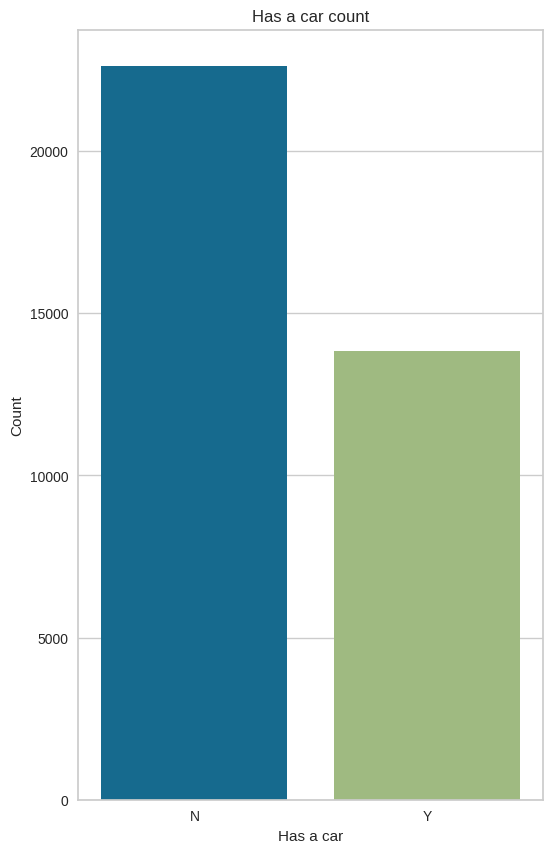

In [69]:
create_bar_plot(full_data, "Has a car")

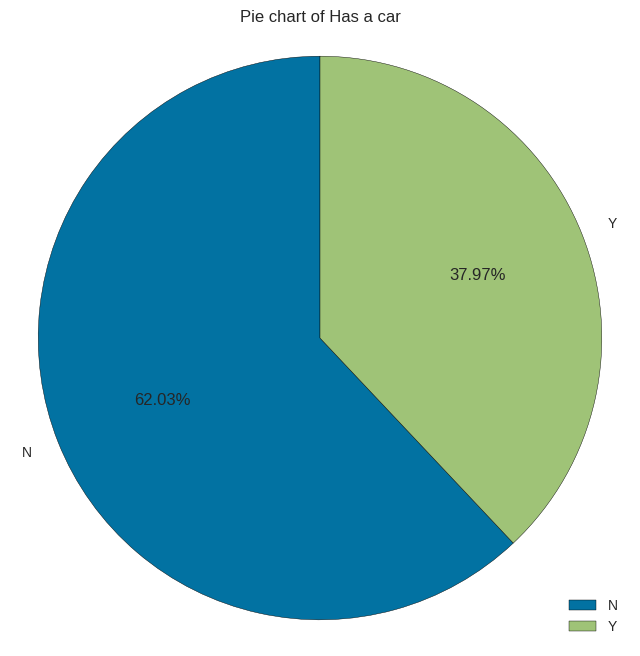

In [70]:
create_pie_plot(full_data, "Has a car")

Nhận xét:
- Đa số mọi người đều không sở hữu xe ô tô riêng

##### 2.3.13 Has a property

In [71]:
get_info_feat(full_data, "Has a property")

Description:
count     36457
unique        2
top           Y
freq      24506
Name: Has a property, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
Y  24506      67.218915
N  11951      32.781085


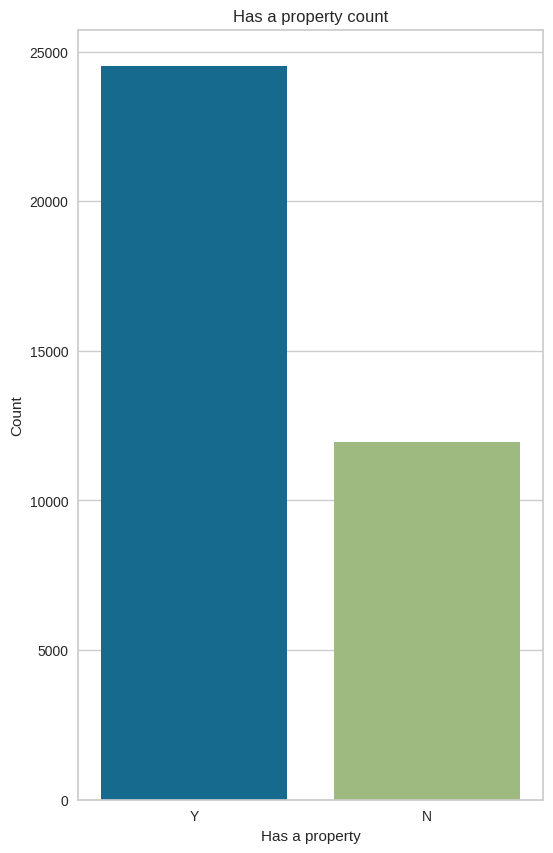

In [72]:
create_bar_plot(full_data, "Has a property")

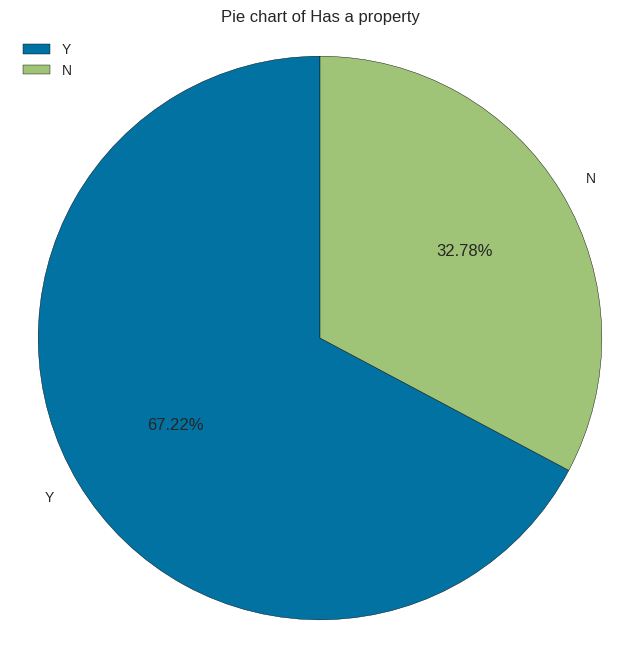

In [73]:
create_pie_plot(full_data, "Has a property")

Nhận xét:
- Đa số mọi người đều có tài sản đảm bảo

#### 2.3.14 Has a work phone

In [74]:
get_info_feat(full_data, "Has a work phone")

Description:
count    36457.000000
mean         0.225526
std          0.417934
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Has a work phone, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
   Count  Frequency (%)
0  28235      77.447404
1   8222      22.552596


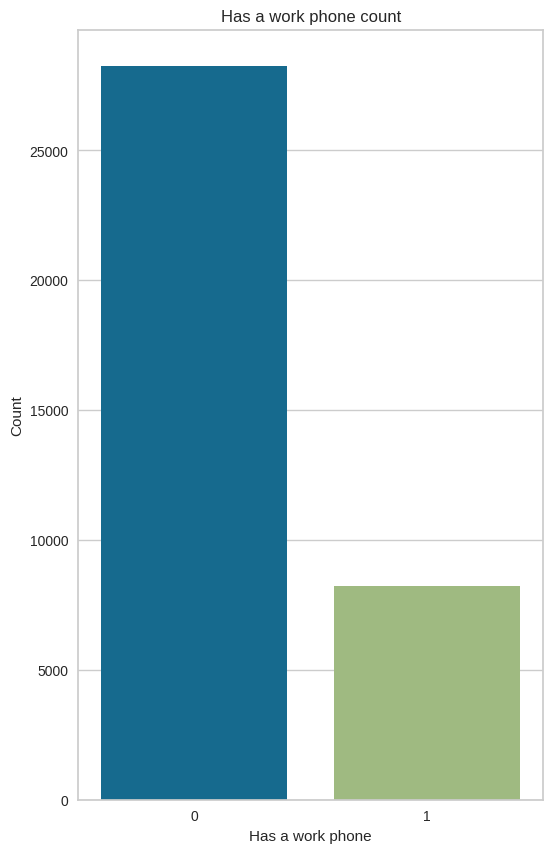

In [75]:
create_bar_plot(full_data, "Has a work phone")

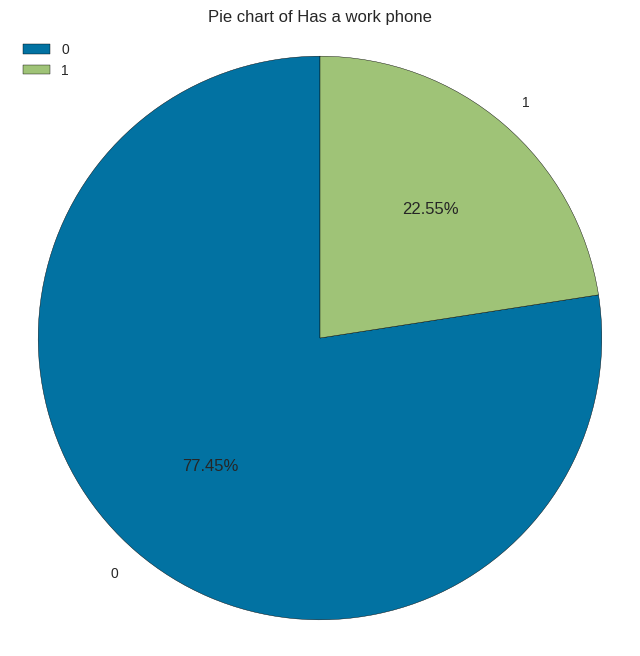

In [76]:
create_pie_plot(full_data, "Has a work phone")

Nhận xét:
- Đa số khách hàng đều không có số điện thoại làm việc riêng

#### 2.3.15 Has a mobile phone

In [77]:
get_info_feat(full_data, "Has a mobile phone")

Description:
count    36457.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: Has a mobile phone, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
   Count  Frequency (%)
1  36457          100.0


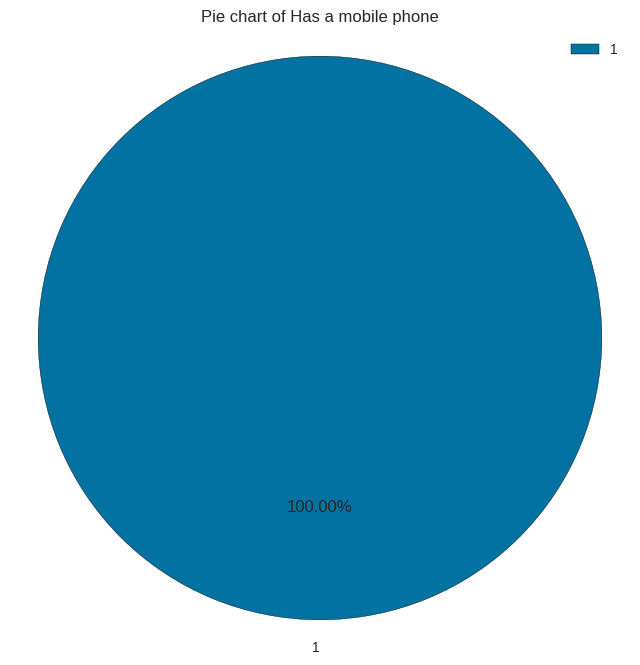

In [78]:
create_pie_plot(full_data, "Has a mobile phone")

Nhận xét:
- Tất cả các khách hàng đều có điện thoại cá nhân riêng

#### 2.3.16 Has a phone (điện thoại bàn)

In [79]:
get_info_feat(full_data, "Has a phone")

Description:
count    36457.000000
mean         0.294813
std          0.455965
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Has a phone, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
   Count  Frequency (%)
0  25709      70.518693
1  10748      29.481307


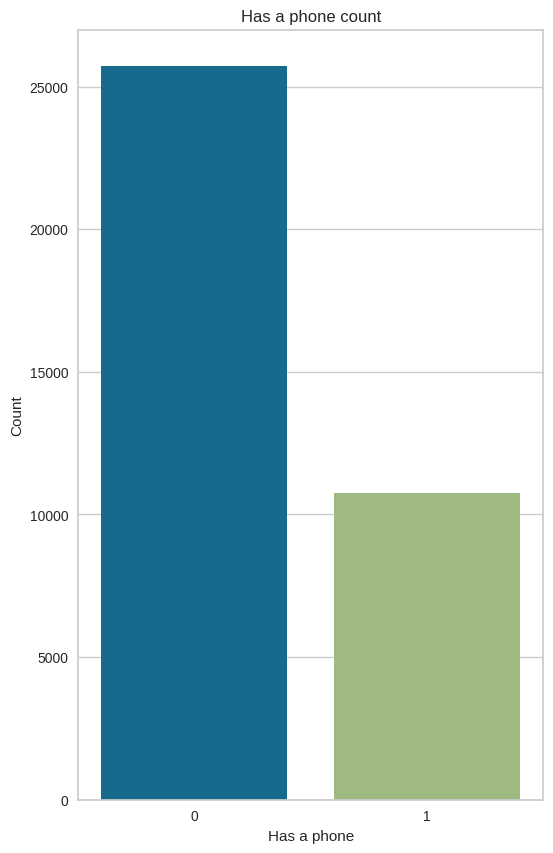

In [80]:
create_bar_plot(full_data, "Has a phone")

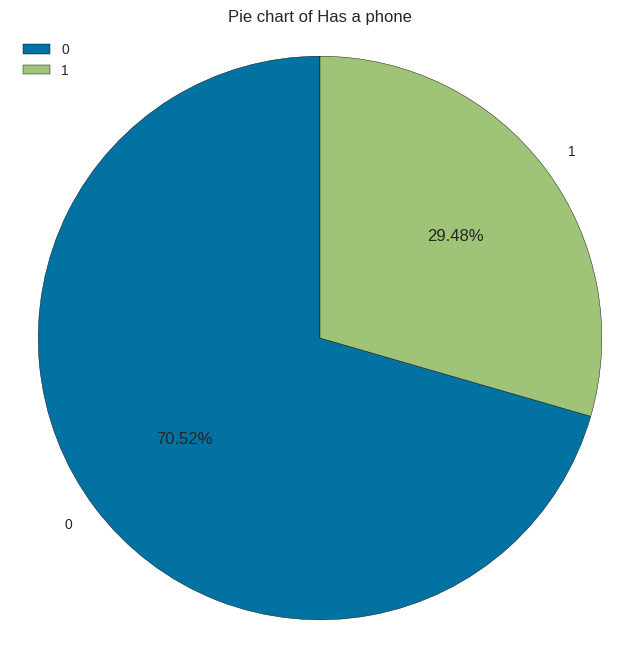

In [81]:
create_pie_plot(full_data, "Has a phone")

Nhận xét:
- Gần 3/4 khách hàng đều không có điện thoại bàn

#### 2.3.17 Has an email

In [82]:
get_info_feat(full_data, "Has an email")

Description:
count    36457.000000
mean         0.089722
std          0.285787
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Has an email, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
   Count  Frequency (%)
0  33186      91.027786
1   3271       8.972214


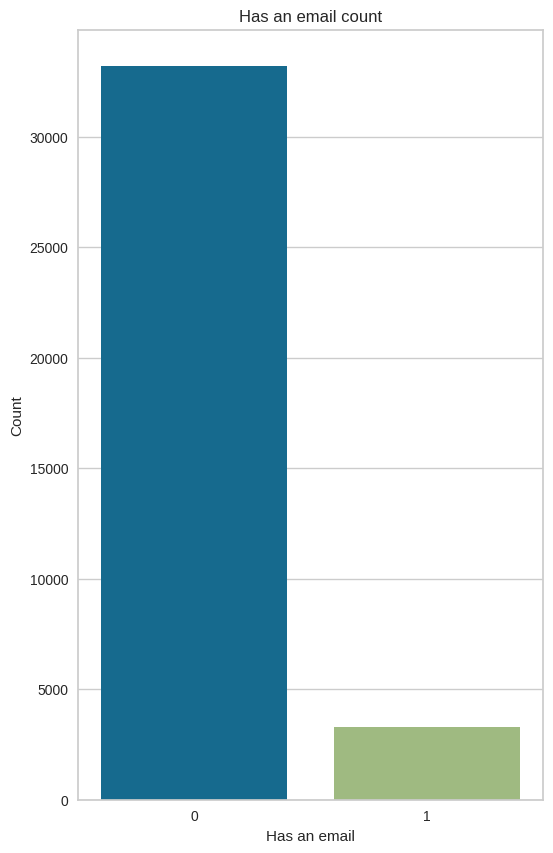

In [83]:
create_bar_plot(full_data, "Has an email")

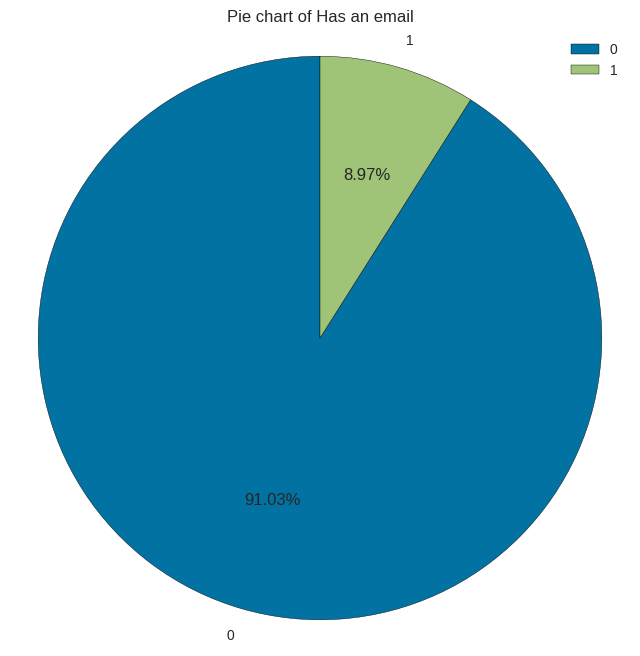

In [84]:
create_pie_plot(full_data, "Has an email")

Nhận xét:
- Đa số khách hàng đều có email chiếm đến 90%

#### 2.3.18 Account age

In [85]:
get_info_feat(full_data, "Account age")

Description:
count    36457.000000
mean        26.164193
std         16.501854
min          0.000000
25%         12.000000
50%         24.000000
75%         39.000000
max         60.000000
Name: Account age, dtype: float64
**************************************************
Object type:float64


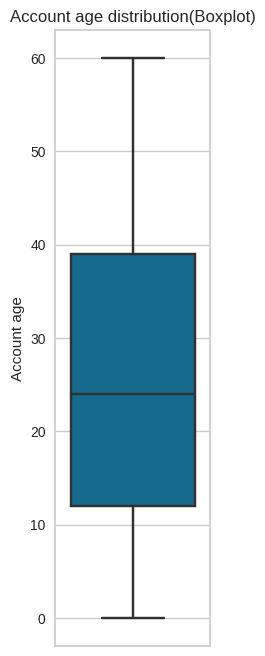

In [86]:
create_box_plot(full_data, "Account age")

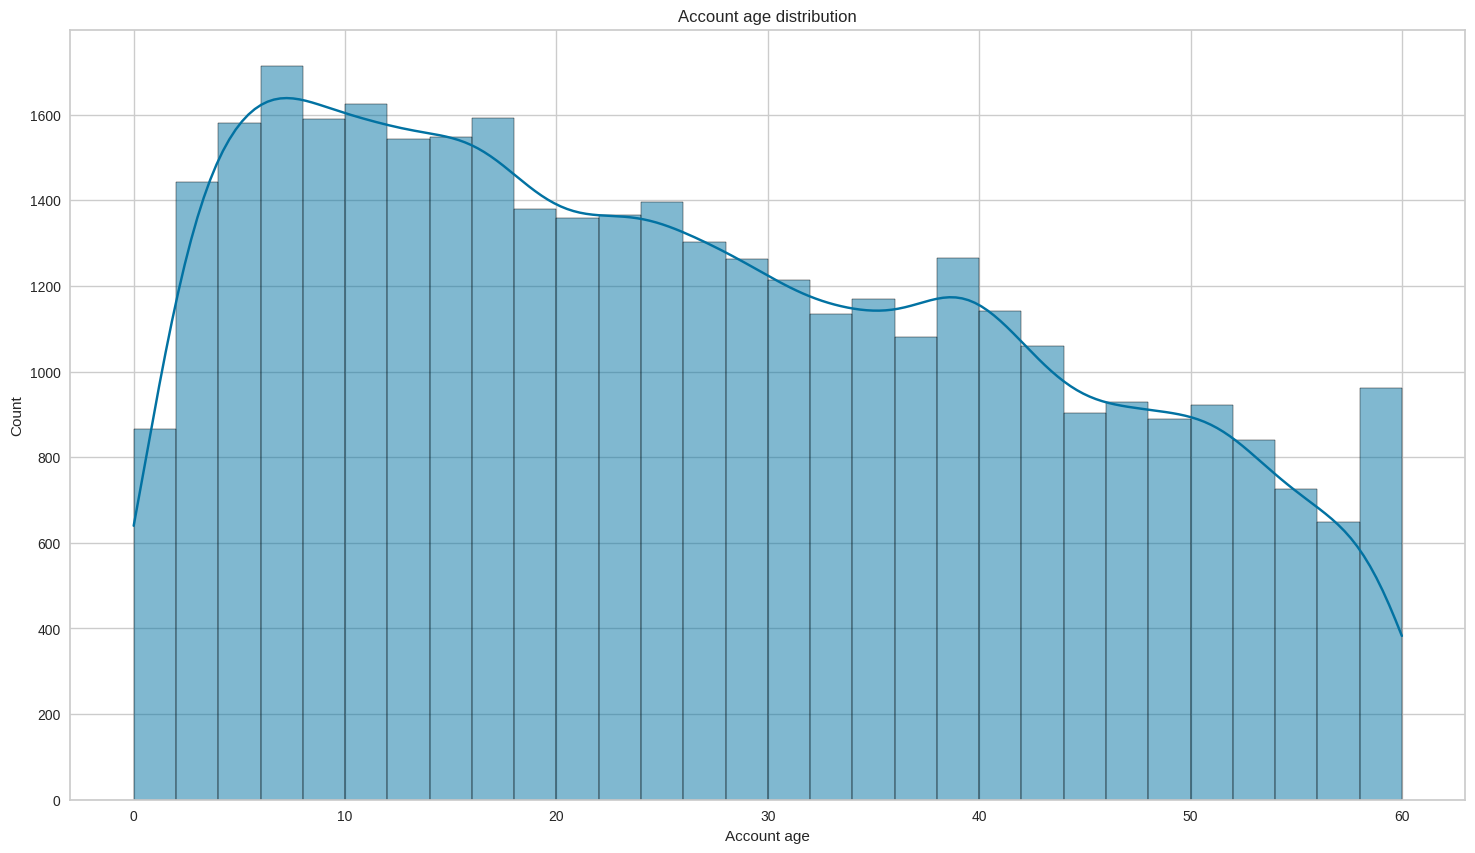

In [87]:
create_hist_plot(full_data, "Account age", the_bins=30)

Is high risk
0    26.033928
1    33.743506
Name: Account age, dtype: float64


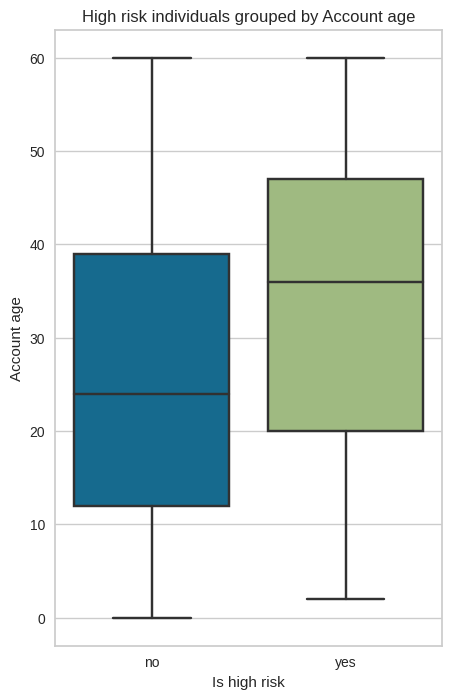

In [88]:
low_high_risk_box_plot(full_data, "Account age")

Nhận xét:
- Trung bình thời gian các tài khoản là 26 tháng.
- Phân phối thời gian tuổi các tài khoản phân phối không phải phân phối chuẩn và có xu hướng lệch trái.
- Các tài khoản có độ tuổi trung bình 34 tháng có độ rủi ro cao hơn.

#### 2.3.19 Is high risk

In [89]:
get_info_feat(full_data, "Is high risk")

Description:
count    36457.000000
mean         0.016897
std          0.128886
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Is high risk, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
   Count  Frequency (%)
0  35841      98.310338
1    616       1.689662


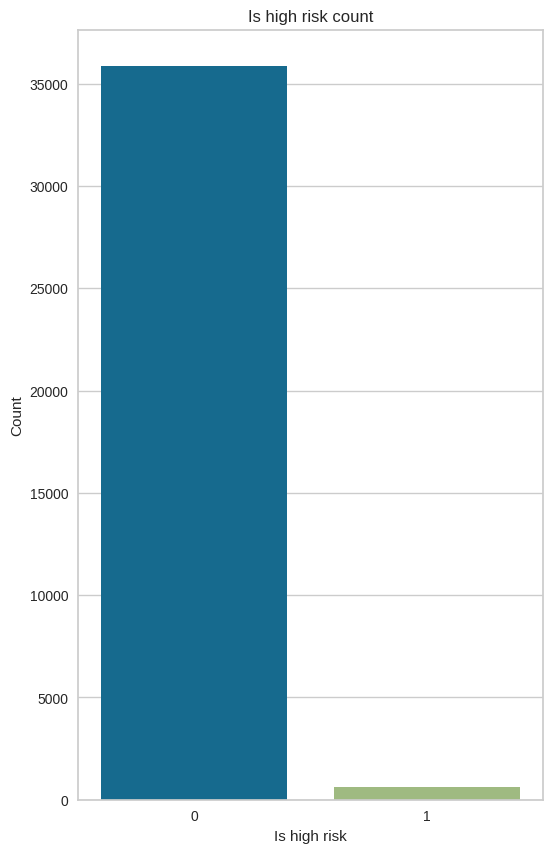

In [90]:
create_bar_plot(full_data, "Is high risk")

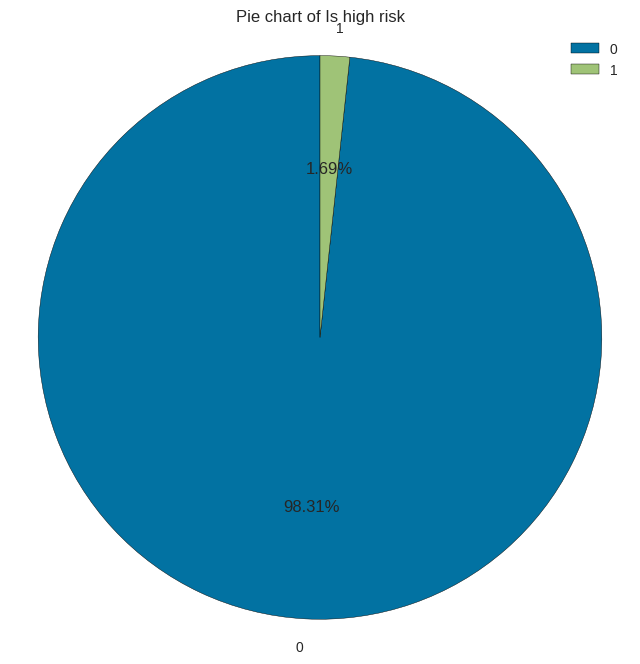

In [91]:
create_pie_plot(full_data, "Is high risk")

Nhận xét:
- Có quá ít data high risk
- Dữ liệu bị lệch quá nhiều

### 2.4 Phân tích đa biến

#### 2.4.1 Phân tích các thuộc tính numberial (Correlation & scatter plots)

#### 2.4.1.1 Scatter plot

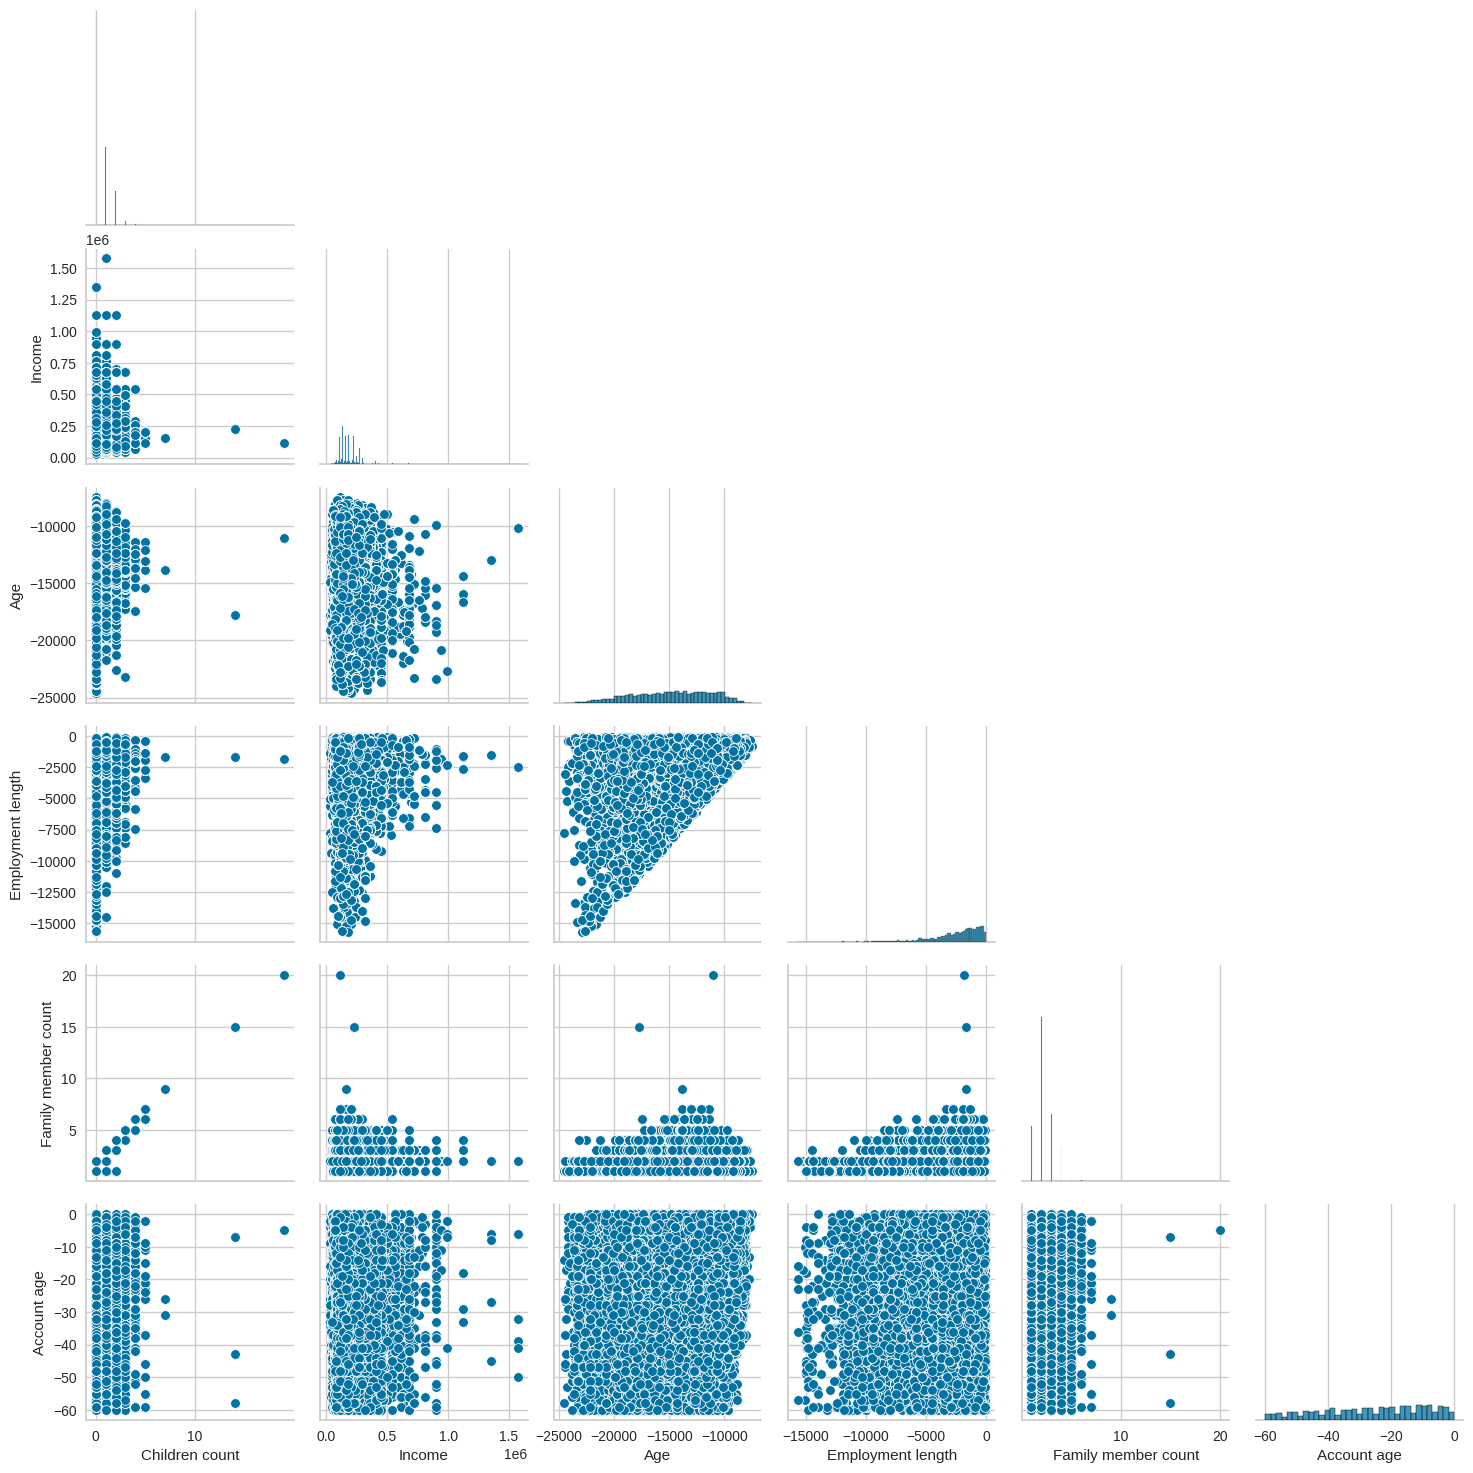

In [92]:
sns.pairplot(full_data[full_data['Employment length'] < 0].drop(['ID','Has a mobile phone', 'Has a work phone', 'Has a phone', 'Has an email','Is high risk'],axis=1),corner=True)
plt.show()
#Loại bỏ các dữ liệu dạng 0 và 1 chỉ lấy các dữ liệu dạng số để thấy được sự tương quan
# Lấy employee length < 0 do các khách hàng còn làm việc thì employee length < 0

Nhận xét:
- Ta thấy một quan hệ tuyến tính giữa Famlmily member count và Children count. Điều này rất có lý vì thêm trẻ có thì thêm thành viên trong gia đình. Nghĩa là 2 cột trên có mối quan hệ tương quan rất lớn nên ta phải bỏ 1 trong hai cột đó đi.
- Ta cũng thấy tuổi càng lớn thì Employee length cũng càng cao. Điều này cũng có đúng vì khi càng thời gian làm việc càng dài thì độ tuổi cũng càng dài hơn.

#### 2.4.1.1.1  Family member count vs children count (numerical vs numerical feature comparison)

<AxesSubplot: xlabel='Children count', ylabel='Family member count'>

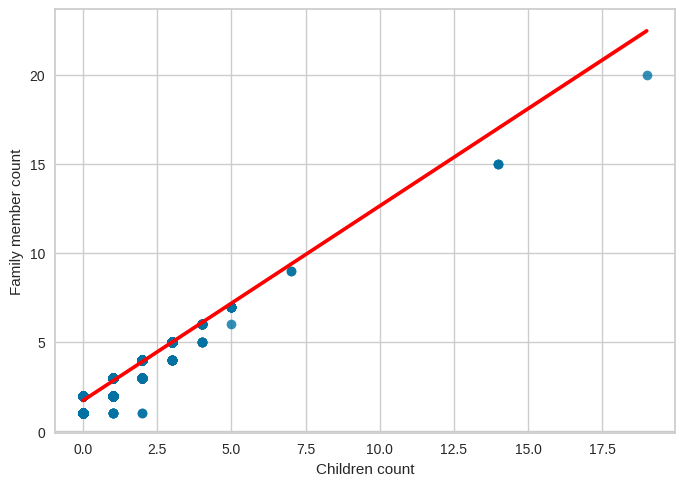

In [93]:
sns.regplot(x= "Children count", y = "Family member count", data= full_data, line_kws={'color': 'red'})

Nhận xét:
- Số lượng trẻ em tỉ lệ thuận với số lượng thành viên trong một gia đình (mối quan hệ tuyến tính)

#### 2.4.1.1.2 Account age vs age (numerical vs numerical feature comparison)

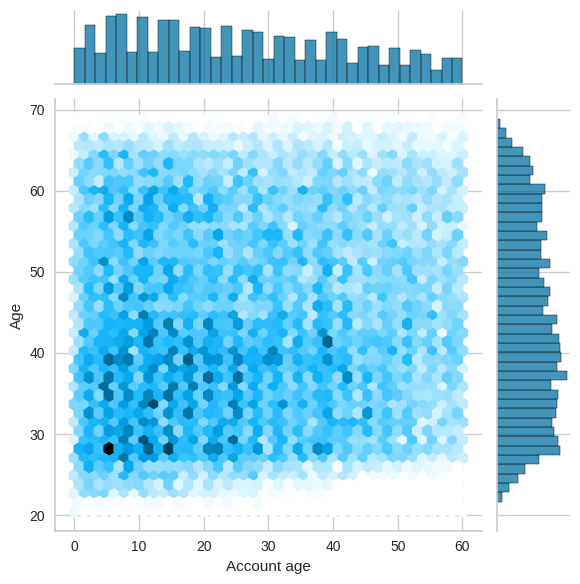

In [94]:
y_age = np.abs(full_data['Age']/365.25)
x_age = np.abs(full_data['Account age'])
x_employee = np.abs(full_data[full_data['Employment length'] < 0]['Employment length'] / 365.25)
data_age = pd.concat([x_age, y_age, x_employee], axis=1)
sns.jointplot(data=data_age, x = "Account age", y = "Age", kind="hex")

Nhận xét:
- Đa số khách hàng có độ tuổi từ 20 đến 45 tuổi và có tài khoản có tuổi là < 25 tháng

#### 2.4.1.1.3 Employment length vs age (numerical vs numerical feature comparison)

<AxesSubplot: xlabel='Employment length', ylabel='Age'>

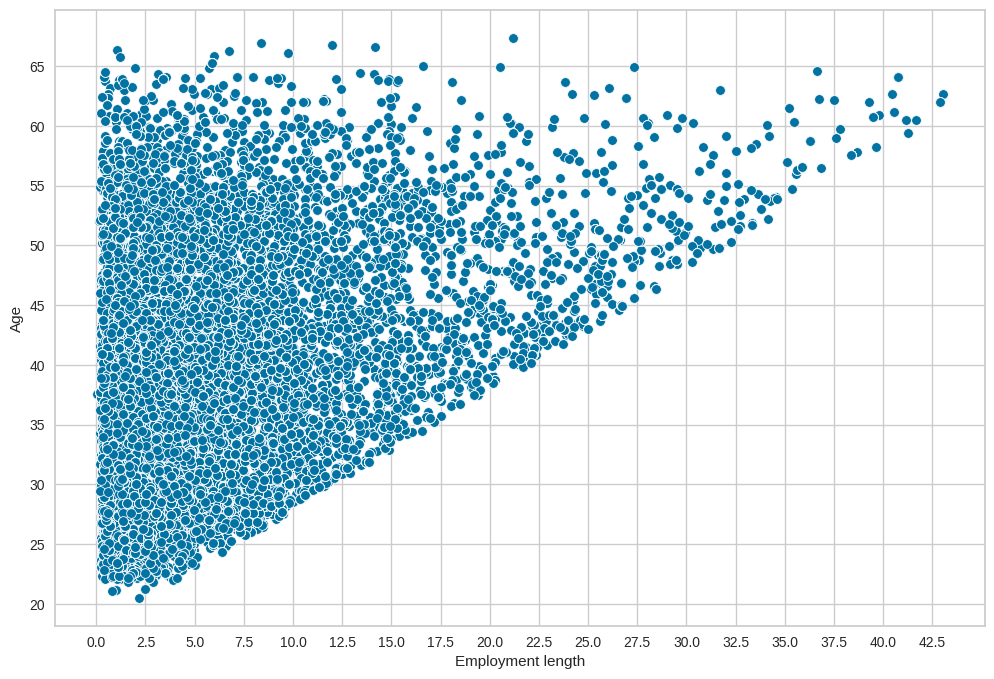

In [95]:
fig, ax = plt.subplots(figsize=(12,8))
plt.xticks(np.arange(0, x_employee.max(), 2.5))
plt.yticks(np.arange(20, y_age.max(), 5))
sns.scatterplot(data=data_age, x= "Employment length", y = "Age")

Nhận xét:
- Ta thấy biểu đồ trên thê thiện hai biến trên là tương quan.  
Biểu đồ trên cho ra một hình như một tam giác trên bởi vì không thể có thời gian làm việc lớn hơn độ tuổi

#### 2.4.1.2 Correlation analysis (Ma trận tương quan)

In [96]:
import math 

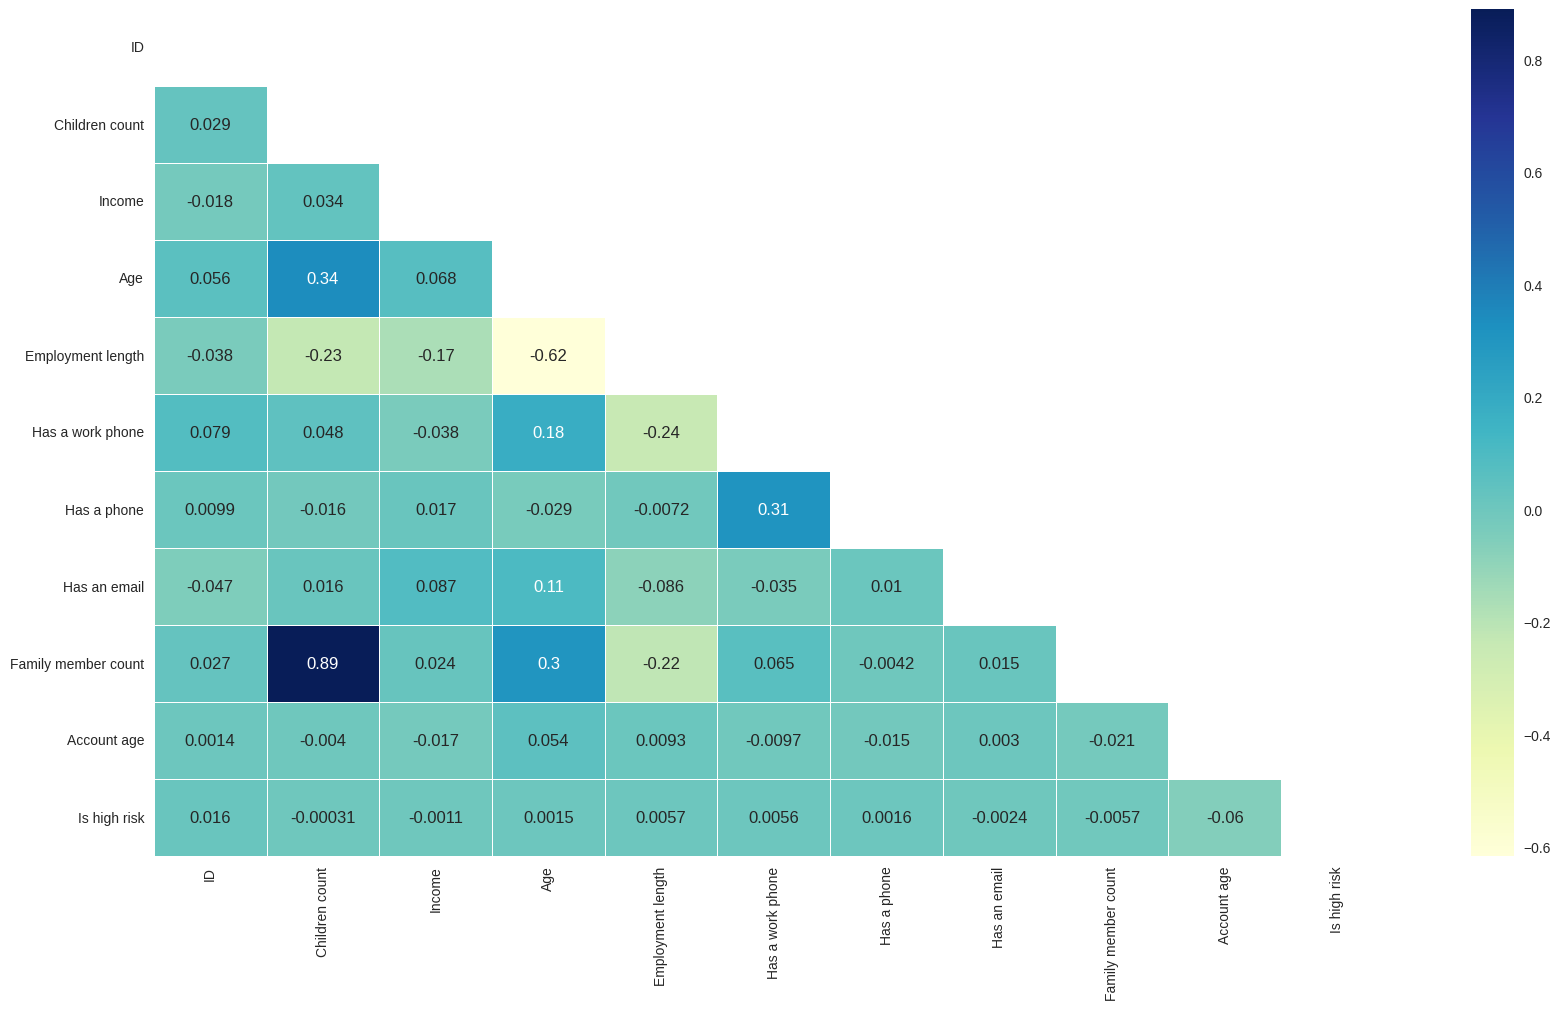

In [97]:
#Loại bỏ biến has a moblie vì biến trên 100% khách hàng đều là 1 nên không quan trọng
full_data_no_mobile = full_data.drop(["Has a mobile phone"], axis=1)
# full_data_no_mobile =  pd.concat([full_data_no_mobile, full_data_no_mobile["Income"] / full_data_no_mobile["Age"],
#                                         full_data_no_mobile["Income"] / full_data_no_mobile["Family member count"],
#                                           full_data_no_mobile["Income"].apply(math.log)] , axis = 1)
full_data_no_mobile = full_data_no_mobile.corr()
#Lấy mask để được ma trận tam tác dưới
mask = np.triu(np.ones_like(full_data_no_mobile))
fig, ax = plt.subplots(figsize=(20,11))
sns.heatmap(full_data_no_mobile, annot=True, mask=mask, linewidths=0.5, cmap="YlGnBu")
plt.show()

In [98]:
full_data['Income']

0        427500.0
1        427500.0
2        112500.0
3        270000.0
4        270000.0
           ...   
36452    315000.0
36453    157500.0
36454    157500.0
36455    283500.0
36456    112500.0
Name: Income, Length: 36457, dtype: float64

Nhận xét:
- Không có biến nào tương quan mạnh với biến mục tiêu là Is high risk
- Biến Family member count và biến Children count tương quan mạnh và có tỉ lệ thuận với nhau, điều này đã được nhận xét ở các biểu đồ trên.
- Biến Age có tương quan nhẹ với biến Family member count, Children count. Điều này cũng có lý vì những người có độ tuổi lớn thì có xu hướng là có số thành viên lớn hơn.
- Biến Has a work phone và biến Has a phone có tính tương quan yếu và tỉ lệ thuận với nhau
- Ta cũng thấy Employment length và Age tương quan trung bình và tỉ lệ nghịch với nhau, điều này đã được nhận xét ở trên

### 2.4.2 Phân tích tương quan biến số so với các biến rời rạc

#### 2.4.2.1 Tương quan giữa biến Age với các biến rời rạc

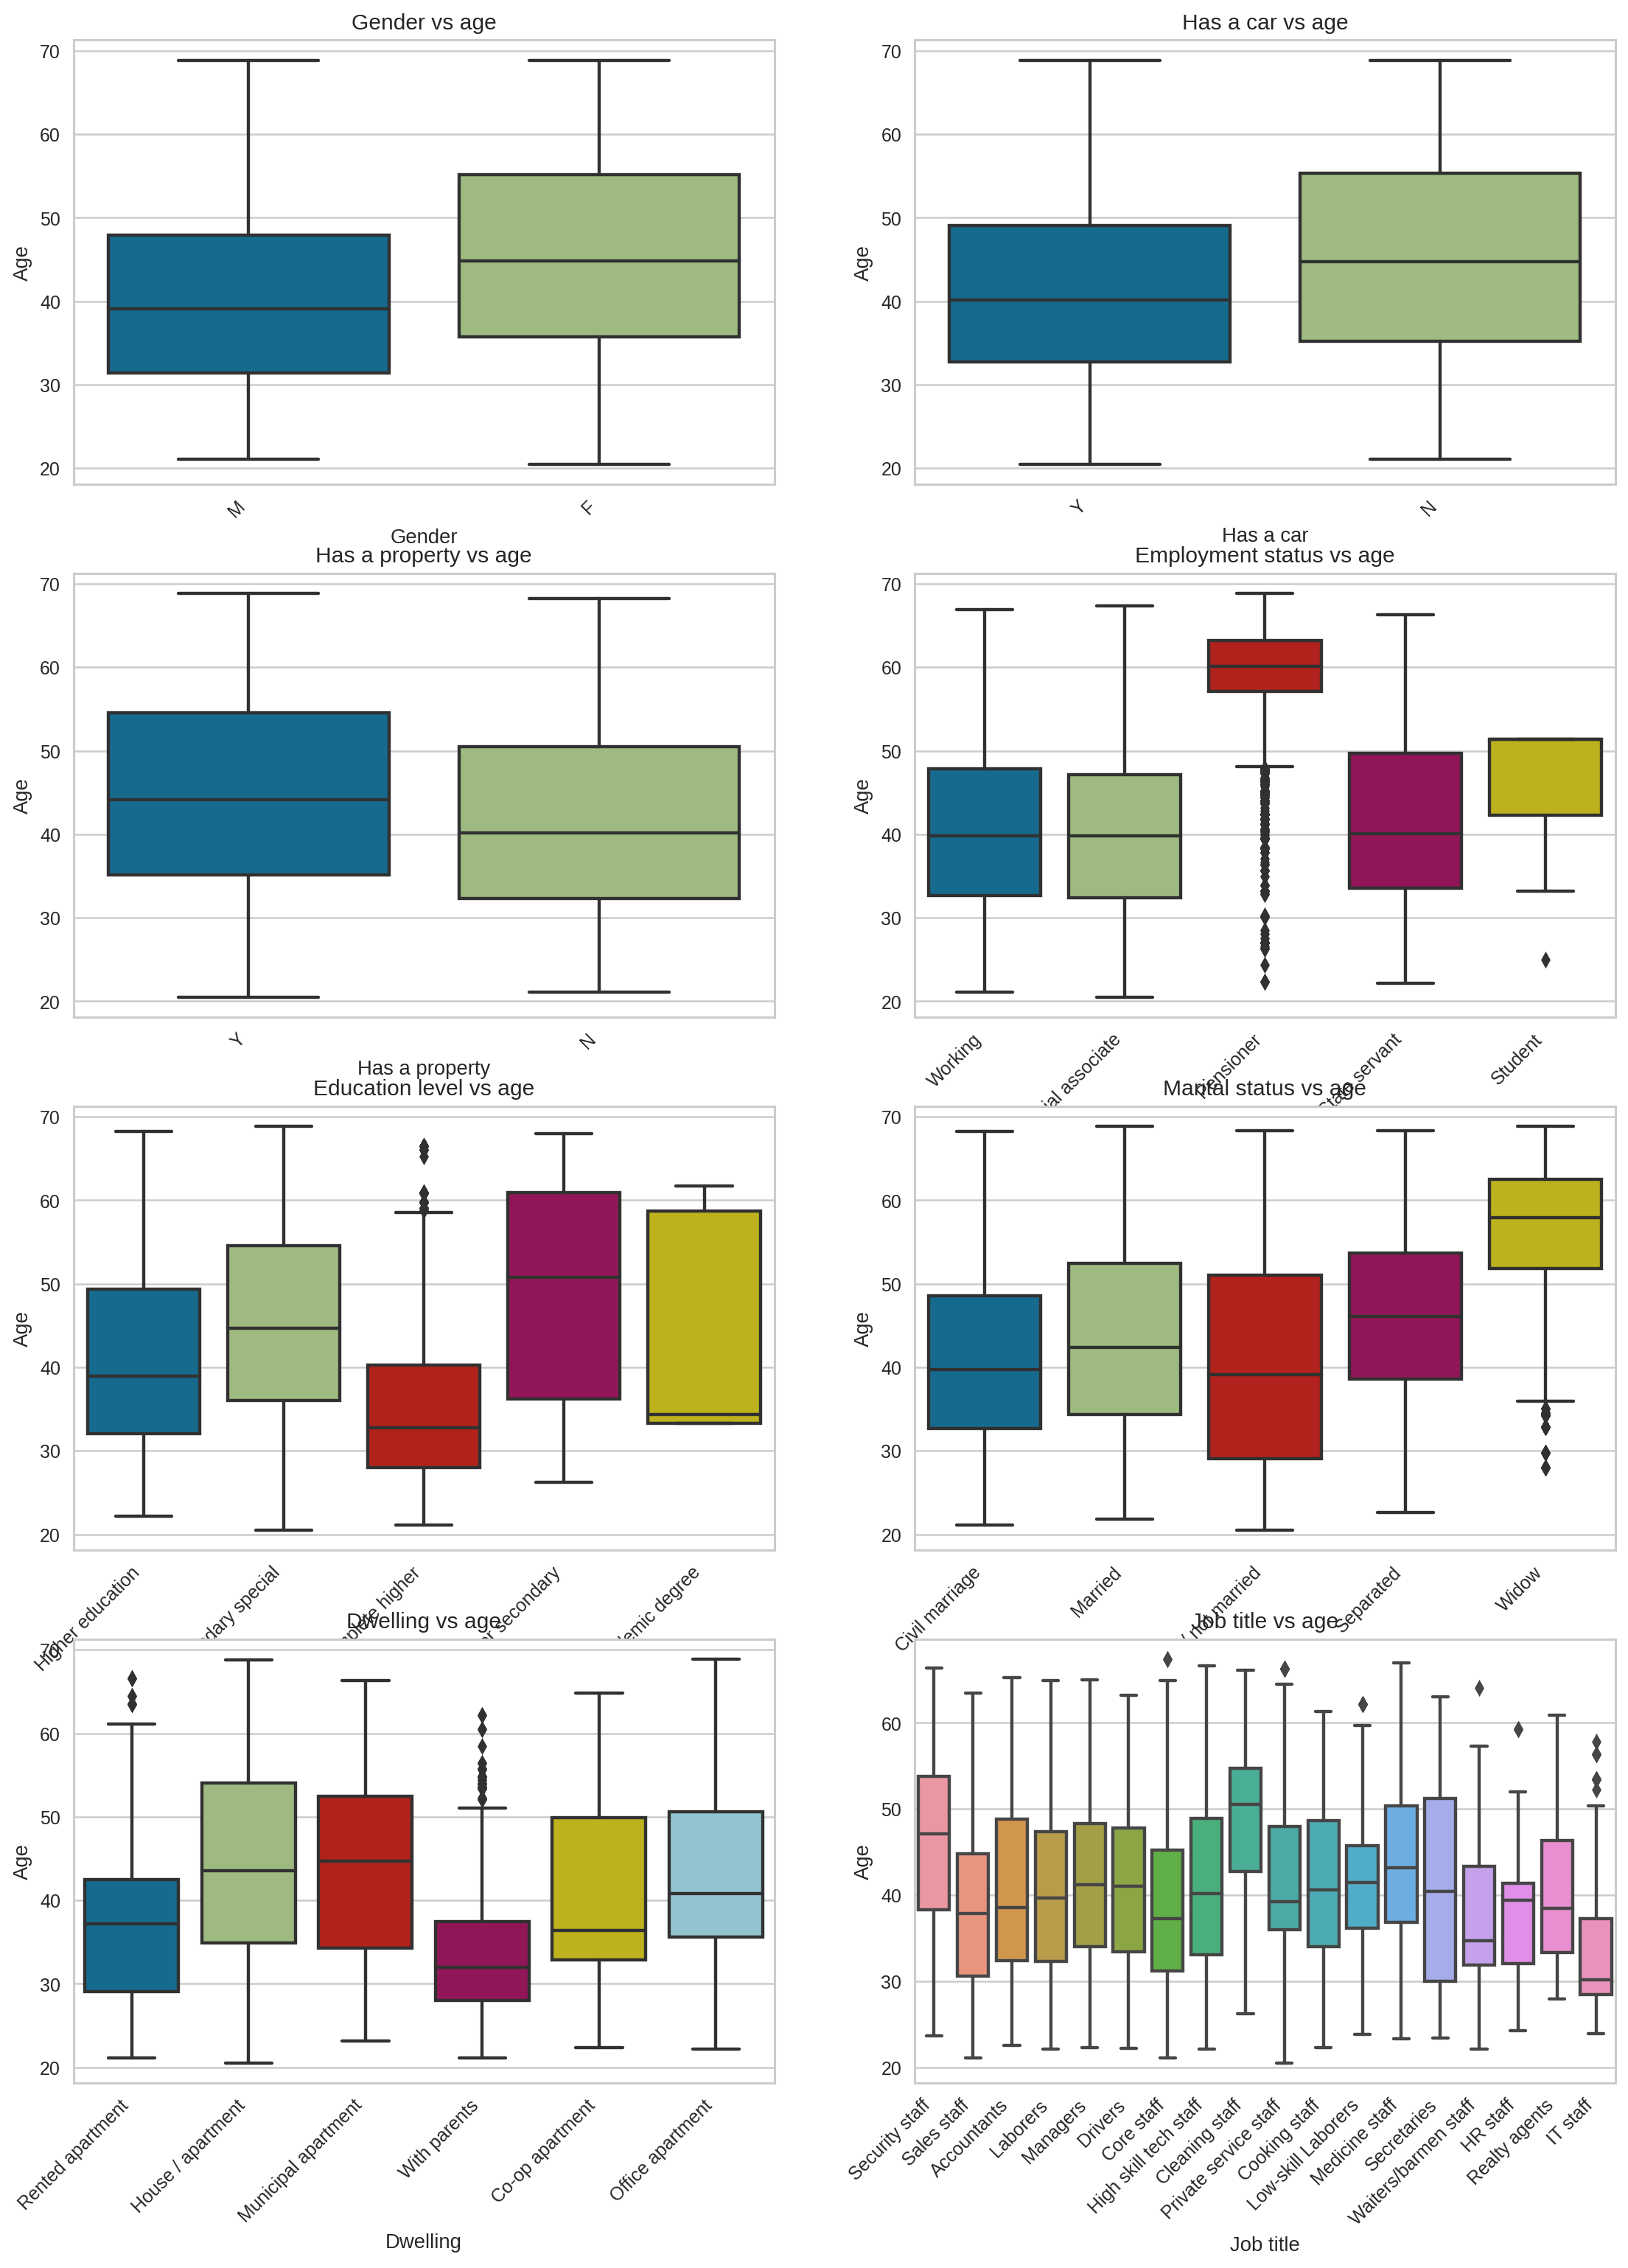

In [99]:
fig, axes = plt.subplots(4,2,figsize=(15,20),dpi=180)
# fig.tight_layout(pad=5.0)
cat_features = ['Gender', 'Has a car', 'Has a property', 'Employment status', 'Education level', 'Marital status', 'Dwelling', 'Job title']
for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):
            sns.boxplot(ax=axes[row_count,feat_count],x=full_data[cat_features[cat_ft_count]],y=np.abs(full_data['Age'])/365.25)
            axes[row_count,feat_count].set_title(cat_features[cat_ft_count] + " vs age")
            plt.sca(axes[row_count,feat_count])
            plt.xticks(rotation=45,ha='right')
            plt.ylabel('Age')
            cat_ft_count += 1
    break

Nhận xét:
- Khách hàng Nữ có độ tuổi trung bình cao hơn so với khách hàng Nam.
- Độ tuổi có xe hơn thường thấp hơn so với không có. Do số lượng có xe chỉ chiếm 30% nên độ tuổi mẫu của người không có sẽ lớn hơn làm cho độ tuổi trung bình của người không có cao hơn.
- Người về hưu có độ tuổi trung bình cao hơn tất cả trạng thái khác. Điều này vô cùng hiển nhiên tuy nhiên ta thấy rất nhiều các outlier nghỉ hưu khi độ tuổi còn trẻ
- Những người sở hữu tài sản đảm bảo có xu hướng cao tuổi hơn những người không có
- Những người góa có số tuổi trung bình cao hơn so với các người khác. Điều này khá dễ hiểu.
- Những người sống với bố mẹ thường có độ tuổi trẻ hơn so với loại khác. Điều này cũng khá dễ hiểu.
- Những người làm công việc dọn dẹp thì thường có độ tuổi cao hơn, những người làm IT hay có độ tuổi trung bình thấp hơn

#### 2.4.2.2 Phân tích tương quan giữa biến Employment length và các biến phân loại khác

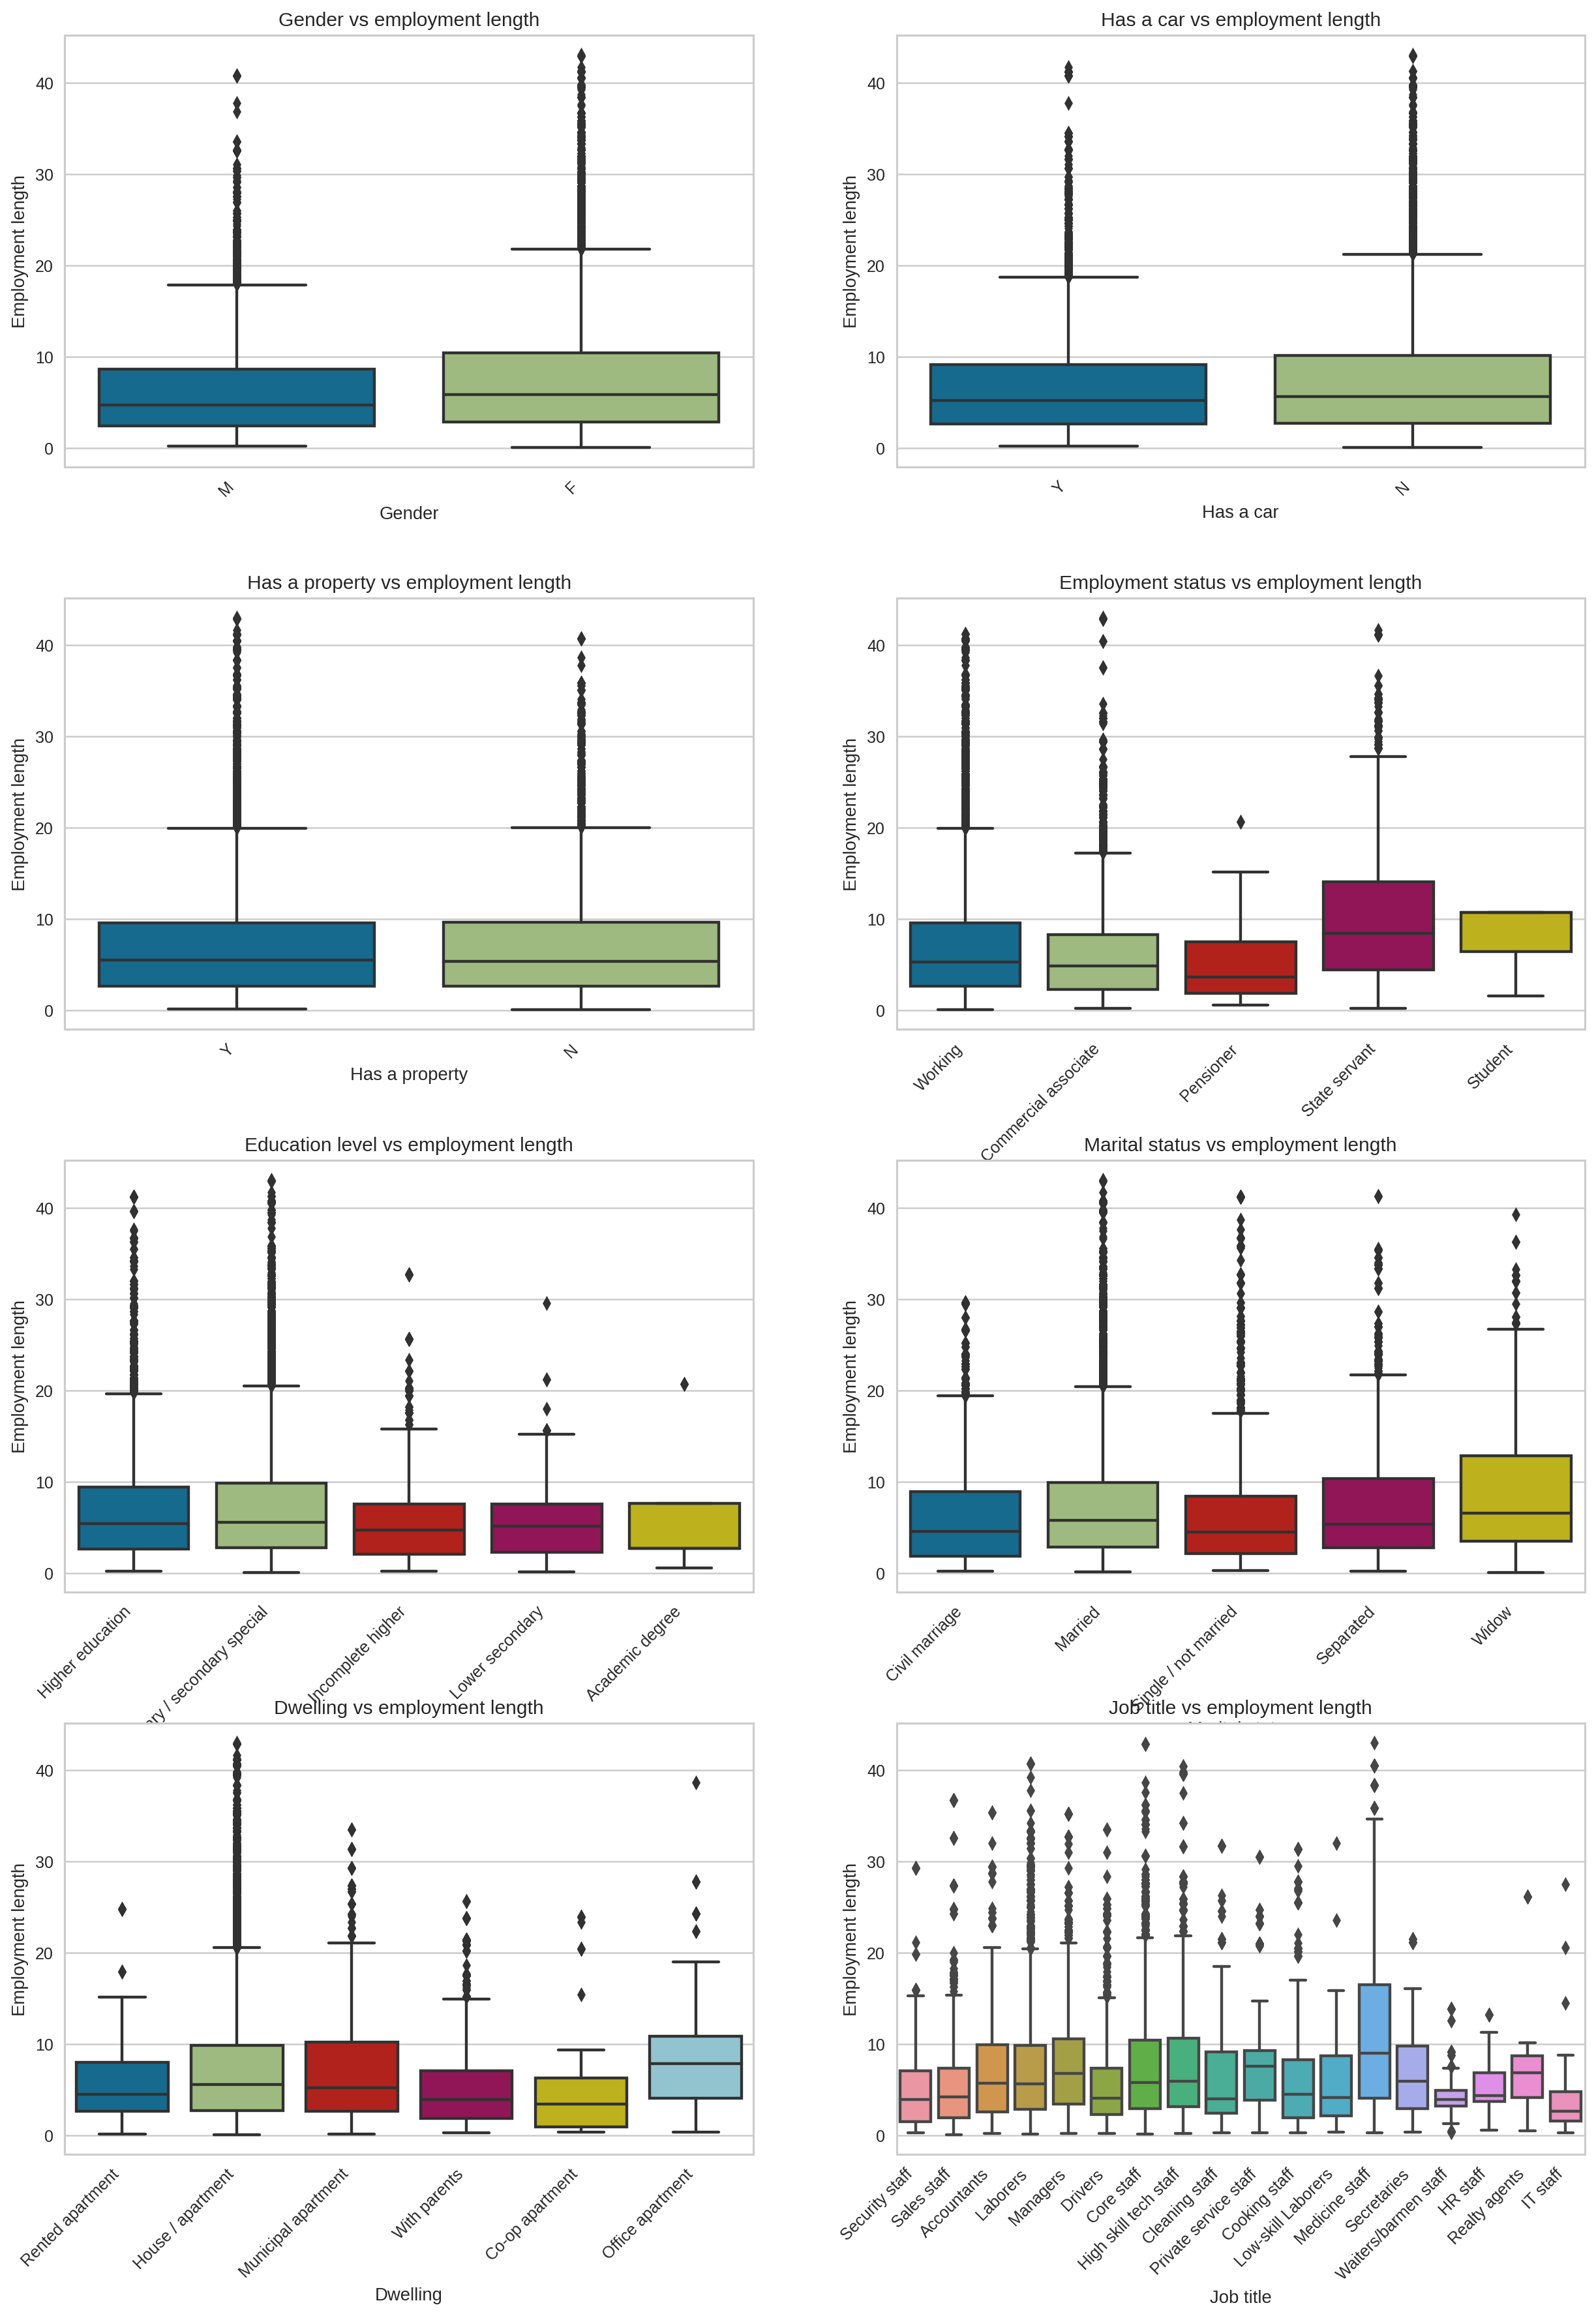

In [100]:
fig, axes = plt.subplots(4,2,figsize=(15,20),dpi=180)
fig.tight_layout(pad=5.0)
#Khoảng cách giữa các hình là 5

for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):
            sns.boxplot(ax=axes[row_count,feat_count],x=full_data[cat_features[cat_ft_count]],y=np.abs(full_data[full_data['Employment length'] < 0]['Employment length'])/365.25)
            axes[row_count,feat_count].set_title(cat_features[cat_ft_count] + " vs employment length")
            plt.sca(axes[row_count,feat_count])
            plt.ylabel('Employment length')
            plt.xticks(rotation=45,ha='right')
            cat_ft_count += 1
    break

Nhận xét:
- Những người làm trong ngành medicine thường có độ tuổi làm việc dài hơn

#### 2.4.3 Categorical vs categorical features (Chi-square test)

##### Tại sao lại là kiểm định Chi-Square
##### -> Bởi vì kiểm định Chi-Square sử dụng cho các biến rời rạc và so sánh được mối quan hệ tương quan giữa Oserved value và Expected value từ đó đưa ra tương quan giữa chúng
##### H0: Có mối quan hệ giữa biến X và Y
##### H1: Không có mối quan hệ giữa X và Y

In [101]:
import scipy.stats as stats

In [102]:
def chi_fun(feature):
    high_risk_ft = full_data[full_data['Is high risk'] == 1][feature]
    high_risk_ft_ct = pd.crosstab(index=high_risk_ft, columns=['Count']).rename_axis(None, axis=1)
    # Drop features's name
    high_risk_ft_ct.index.name = None
    # observe values (Biến quan sát)
    obs = high_risk_ft_ct
    print('Observed values:\n')
    print(obs)
    print("\n")
    #expected values
    print('Expected values')
    exp = pd.DataFrame([obs["Count"].sum()/len(obs)] * len(obs.index), columns = ["Count"], index=obs.index)
    print(exp)
    print("\n")
    #Chi-quare test
    print("Chi-quare test")
    chi_quare_stat = (((obs - exp) ** 2) / exp).sum()
    print(chi_quare_stat[0])
    print("\n")
    #Critical values
    # q là độ tin cậy, df là degree freedom (bậc tự do) bằng n -1
    crit = stats.chi2.ppf(q=0.95, df = len(obs) - 1)
    print("Critical values")
    print(crit)
    print("\n")
    # p - value
    print("P-value")
    p_value = 1- stats.chi2.cdf(x = chi_quare_stat, df = len(obs) - 1)
    print(p_value[0])
    print("\n")
    if(chi_quare_stat[0] >= crit):
        print("Từ Chối giải thiết có các giá trị ngoài khoảng tin cậy")
    else:
        print("Chấp nhận giải thiết có các giá trị ngoài khoảng tin cậy")

In [103]:
cat_ft = ['Gender', 'Has a car', 'Has a property', 'Employment status', 'Education level', 'Marital status', 'Dwelling', 'Job title']
for ft in cat_ft:
    print('\n\n**** {} ****\n'.format(ft))
    chi_fun(ft)



**** Gender ****

Observed values:

   Count
F    379
M    237


Expected values
   Count
F  308.0
M  308.0


Chi-quare test
32.73376623376623


Critical values
3.841458820694124


P-value
1.0568526387366717e-08


Từ Chối giải thiết có các giá trị ngoài khoảng tin cậy


**** Has a car ****

Observed values:

   Count
N    392
Y    224


Expected values
   Count
N  308.0
Y  308.0


Chi-quare test
45.81818181818182


Critical values
3.841458820694124


P-value
1.297539853339913e-11


Từ Chối giải thiết có các giá trị ngoài khoảng tin cậy


**** Has a property ****

Observed values:

   Count
N    251
Y    365


Expected values
   Count
N  308.0
Y  308.0


Chi-quare test
21.0974025974026


Critical values
3.841458820694124


P-value
4.365194105293568e-06


Từ Chối giải thiết có các giá trị ngoài khoảng tin cậy


**** Employment status ****

Observed values:

                      Count
Commercial associate    143
Pensioner               130
State servant            37
Working           

## 3. Preprare the data

### 3.1 Transform data for each feature

<ul>ID<br>
    <li>Remove feature </li>
</ul>
<ul>Gender<br>
    <li>On hot conding </li>
</ul>
<ul>Age<br>
    <li>Min max scalling </li>
    <li>Fix skewnes </li>
    <li>Abs value and div </li>
</ul>
<ul>
Martial status<br>
    <li> On hot coding </li>
</ul>
<ul>Children count<br>
    <li> Fix outliers </li>
    <li> Drop features </li>
</ul>
<ul>Dwelling type<br>
    <li> On hot encoding </li>
</ul>
<ul>
Income<br>
    <li> Remove outliers </li>
    <li> Fix skewness </li>
    <li> Min max scalling </li>
</ul>
<ul>Job titile<br>
    <li>  On hot conding </li>
    <li> Fill  missing values </li>
</ul>

<ul>Employment status<br>
    <li> Order by enconding </li>
</ul>

<ul>Employment length<br>
    <li>Remove outliers</li>
    <li>Min-max scaling</li>
    <li>Abs value and div 365.25</li>
    <li>change days of employments of retirees to 0</li>
</ul>
<ul>Has a car <br>
    <li>Change it numerical</li>
    <li>One-hot encoding</li>
</ul>

<ul>Has a property: <br>
    <li>Change it numerical</li>
    <li>One-hot encoding</li>
</ul>

<ul>Has a mobile phone: <br>
    <li>Drop feature</li>
</ul>
<ul>Has a work phone: <br>
    <li>One-hot encoding</li>
</ul>
<ul>Has a phone<br>
    <li>One-hot encoding</li>
</ul>
<ul>Has a email: <br>
    <li>One-hot encoding</li>
</ul>
<ul>Account age: <br>
    <li>Drop table</li>
</ul>
<ul>
Is high risk(Target):<br>
    <li>Change the data type to numerical</li>
    <li> balance the data with SMOTE</li>
</ul>

### 3.2 Data cleaning

#### 3.2.1 Outlier  handling

In [104]:
#Xóa các Outlier với các thuộc tính có nhiều Outlier
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_outliers = ['Family member count','Income', 'Employment length']):
        self.feat_with_outliers = feat_with_outliers
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_outliers).issubset(df.columns)):
            # 25% quantile
            Q1 = df[self.feat_with_outliers].quantile(.25)
            # 75% quantile
            Q3 = df[self.feat_with_outliers].quantile(.75)
            IQR = Q3 - Q1
            # keep the data within 3 IQR
            df = df[~((df[self.feat_with_outliers] < (Q1 - 3 * IQR)) |(df[self.feat_with_outliers] > (Q3 + 3 * IQR))).any(axis=1)]
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### 3.3 Feture Selection

#### 3.3.1 Drop Features

In [105]:
class DropFeatures(BaseEstimator,TransformerMixin):
    def __init__(self,feature_to_drop = ['ID','Has a mobile phone','Children count','Job title','Account age']):
        self.feature_to_drop = feature_to_drop
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feature_to_drop).issubset(df.columns)):
            df.drop(self.feature_to_drop,axis=1,inplace=True)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

+ ID : Không có giá trí khi ta áp dụng mô hình dự đoán, ID chỉ giúp merge các bảng.
+ Has a mobile phone: tất cả mọi người đều có mobile phone nên thuộc tính này không còn quan trọng.
+ Children count: do thuộc tính có tính tương quan rất cao với Family count nên ta chọn một trong hai thuộc tính mang tính tổng quát hơn.
+ Job title: do bị thiếu quá nhiều dữ liệu nên ta cũng bỏ đi.
+ Account age: ...


### 3.4 Feature engineering

#### 3.4.1 Time conversion (Chuẩn hóa thời gian)

In [106]:
class TimeConversionHandler(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_days = ['Employment length', 'Age']):
        self.feat_with_days = feat_with_days
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if (set(self.feat_with_days).issubset(X.columns)):
            # convert days to absolute value
            X[['Employment length','Age']] = np.abs(X[['Employment length','Age']])
            return X
        else:
            print("One or more features are not in the dataframe")
            return X

#### 3.4.2 Retiree handling (in the employment length feature)

In [107]:
# Chuyển những người đã nghỉ hưu số ngày thành 0
class RetireeHandler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, df):
        return self
    def transform(self, df):
        if 'Employment length' in df.columns:
            # select rows with employment length is 365243 which corresponds to retirees
            df_ret_idx = df['Employment length'][df['Employment length'] == 365243].index
            # change 365243 to 0
            df.loc[df_ret_idx,'Employment length'] = 0
            return df
        else:
            print("Employment length is not in the dataframe")
            return df

#### 3.4.3 Skewness handling(Giảm nhiễu giữa các khoảng dữ liệu)

In [108]:
## Do phân phối của Income và Age quá tương lệch và tập trung ở một khoảng lớn
class SkewnessHandler(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_skewness=['Income','Age']):
        self.feat_with_skewness = feat_with_skewness
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_skewness).issubset(df.columns)):
            # Handle skewness with cubic root transformation
            df[self.feat_with_skewness] = np.cbrt(df[self.feat_with_skewness])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

#### 3.4.4 Binning

In [109]:
#Ta chuyển đổi các thuộc tính sau thành Y và N
class BinningNumToYN(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_num_enc=['Has a work phone','Has a phone','Has an email']):
        self.feat_with_num_enc = feat_with_num_enc
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_num_enc).issubset(df.columns)):
            # Change 0 to N and 1 to Y for all the features in feat_with_num_enc
            for ft in self.feat_with_num_enc:
                df[ft] = df[ft].map({1:'Y',0:'N'})
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

#### 3.4.5 One hot encoding (with feature's name)

In [110]:
# Đối với các dữ liệu không phụ thuộc
class OneHotWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,one_hot_enc_ft = ['Gender', 'Marital status', 'Dwelling', 'Employment status', 'Has a car', 'Has a property', 'Has a work phone', 'Has a phone', 'Has an email']):
        self.one_hot_enc_ft = one_hot_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.one_hot_enc_ft).issubset(df.columns)):
            # function to one hot encode the features in one_hot_enc_ft
            def one_hot_enc(df,one_hot_enc_ft):
                one_hot_enc = OneHotEncoder()
                one_hot_enc.fit(df[one_hot_enc_ft])
                # get the result of the one hot encoding columns names
                feat_names_one_hot_enc = one_hot_enc.get_feature_names_out(one_hot_enc_ft)
                # change the array of the one hot encoding to a dataframe with the column names
                df = pd.DataFrame(one_hot_enc.transform(df[self.one_hot_enc_ft]).toarray(),columns=feat_names_one_hot_enc,index=df.index)
                return df
            # function to concatenat the one hot encoded features with the rest of features that were not encoded
            def concat_with_rest(df,one_hot_enc_df,one_hot_enc_ft):
                # get the rest of the features
                rest_of_features = [ft for ft in df.columns if ft not in one_hot_enc_ft]
                # concatenate the rest of the features with the one hot encoded features
                df_concat = pd.concat([one_hot_enc_df, df[rest_of_features]],axis=1)
                return df_concat
            # one hot encoded dataframe
            one_hot_enc_df = one_hot_enc(df,self.one_hot_enc_ft)
            # returns the concatenated dataframe
            full_df_one_hot_enc = concat_with_rest(df,one_hot_enc_df,self.one_hot_enc_ft)
            return full_df_one_hot_enc
        else:
            print("One or more features are not in the dataframe")
            return df

#### 3.4.6 Ordinal encoding (with feature's names)


In [111]:
# Encoding với các biến phụ thuộc(tức là có phân biệt thứ tự)
class OrdinalFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,ordinal_enc_ft = ['Education level']):
        self.ordinal_enc_ft = ordinal_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Education level' in df.columns:
            ordinal_enc = OrdinalEncoder()
            df[self.ordinal_enc_ft] = ordinal_enc.fit_transform(df[self.ordinal_enc_ft])
            return df
        else:
            print("Education level is not in the dataframe")
            return df

Phân biệt biến phụ thuộc và không phụ thuộc: 
[here](https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/)

#### 3.4.7 Min-Max scaling (with feature's names)

##### Tại sao lại dùng Min-max scalling?
Min-max scalling chỉ là thu nhỏ lại khoảng giá trị mà không làm thay đổi hình dạng phân phối

In [112]:
class MinMaxWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,min_max_scaler_ft = ['Age', 'Income', 'Employment length']):
        self.min_max_scaler_ft = min_max_scaler_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.min_max_scaler_ft).issubset(df.columns)):
            min_max_enc = MinMaxScaler()
            df[self.min_max_scaler_ft] = min_max_enc.fit_transform(df[self.min_max_scaler_ft])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

#### 3.4.8 Change the data types of the target feature

In [113]:
class ChangeToNumTarget(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Is high risk' in df.columns:
            df['Is high risk'] = pd.to_numeric(df['Is high risk'])
            return df
        else:
            print("Is high risk is not in the dataframe")
            return df

#### 3.4.9 Oversampling

In [114]:
class Oversample(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Is high risk' in df.columns:
            # smote function to oversample the minority class to fix the imbalance data
            oversample = SMOTE(sampling_strategy='minority')
            X_bal, y_bal = oversample.fit_resample(df.loc[:, df.columns != 'Is high risk'],df['Is high risk'])
            df_bal = pd.concat([pd.DataFrame(X_bal),pd.DataFrame(y_bal)],axis=1)
            return df_bal
        else:
            print("Is high risk is not in the dataframe")
            return df

Tại sao phải lấy dữ oversampling: [here](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

Ta cần học sử dụng oversamping bởi vì mẫu có giá trị là Is high risk quá thấp trong dữ liệu

### 3.5 Data preprocess

In [115]:
def full_pipeline(df):
    # Create the pipeline that will call all the class from OutlierRemoval to OversampleSMOTE in one go
    pipeline = Pipeline([
        ('outlier_remover', OutlierRemover()),
        ('feature_dropper', DropFeatures()),
        ('time_conversion_handler', TimeConversionHandler()),
        ('retiree_handler', RetireeHandler()),
        ('skewness_handler', SkewnessHandler()),
        ('binning_num_to_yn', BinningNumToYN()),
        ('one_hot_with_feat_names', OneHotWithFeatNames()),
        ('ordinal_feat_names', OrdinalFeatNames()),
        ('min_max_with_feat_names', MinMaxWithFeatNames()),
        ('change_to_num_target', ChangeToNumTarget()),
        ('oversample', Oversample())
    ])
    df_pipe_prep = pipeline.fit_transform(df)
    return df_pipe_prep

In [116]:
train_prep = full_pipeline(train_copy)

In [117]:
train_prep.shape

(46544, 34)

In [118]:
# split the train data into X and y (target)
X_cc_train_prep, y_cc_train_prep = train_prep.loc[:, train_prep.columns != 'Is high risk'], train_prep['Is high risk'].astype('int64')

# 4. Short-list promising models

## 4.1 Model training

In [119]:
classifiers = {
    # 'sgd':SGDClassifier(random_state=42,loss='perceptron'),
    # 'logistic_regression':LogisticRegression(random_state=42,max_iter=1000),
    # 'support_vector_machine':SVC(random_state=42,probability=True),
    # 'decision_tree':DecisionTreeClassifier(random_state=42),
    'random_forest':RandomForestClassifier(random_state=42),
    # 'gaussian_naive_bayes':GaussianNB(),
    # 'k_nearest_neighbors':KNeighborsClassifier(),
    # 'gradient_boosting':GradientBoostingClassifier(random_state=42),
    # 'linear_discriminant_analysis':LinearDiscriminantAnalysis(),
    # 'bagging':BaggingClassifier(random_state=42),
    # 'neural_network':MLPClassifier(random_state=42,max_iter=1000),
    # 'adaboost':AdaBoostClassifier(random_state=42),
    # 'extra_trees':ExtraTreesClassifier(random_state=42),
    }

In [120]:
# Function to get the feature importance of the classifier, and plot it
def feat_importance_plot(model_trn, model_name):
    if model_name not in ['sgd','support_vector_machine','gaussian_naive_bayes','k_nearest_neighbors','bagging','neural_network']:
        # change xtick font size
        plt.rcParams['xtick.labelsize'] = 12
        plt.rcParams['ytick.labelsize'] = 12
        # top 10 most predictive features
        top_10_feat = FeatureImportances(model_trn, relative=False, topn=10)
        # top 10 least predictive features
        bottom_10_feat = FeatureImportances(model_trn, relative=False, topn=-10)
        #change the figure size
        plt.figure(figsize=(10, 4))
        #change x label font size
        plt.xlabel('xlabel', fontsize=14)
        # Fit to get the feature importances
        top_10_feat.fit(X_cc_train_prep, y_cc_train_prep)
        # show the plot
        top_10_feat.show()
        print('\n')
        plt.figure(figsize=(10, 4))
        plt.xlabel('xlabel', fontsize=14)
        # Fit to get the feature importances
        bottom_10_feat.fit(X_cc_train_prep, y_cc_train_prep)
        # show the plot
        bottom_10_feat.show()
        print('\n')
    else:
        print('No feature importance for {0}'.format(model_name))
        print('\n')

In [121]:
# Function to get the y prediction
def y_prediction_func(model_trn,model_name,final_model=False):
    if final_model == False:
        # check if y_train_copy_pred exists, if not create it
        y_cc_train_pred_path = Path('saved_models/{0}/y_train_copy_pred_{0}.sav'.format(model_name))
        try:
            y_cc_train_pred_path.resolve(strict=True)
        except FileNotFoundError:
            #cross validation prediction with kfold = 10
            y_cc_train_pred = cross_val_predict(model_trn,X_cc_train_prep,y_cc_train_prep,cv=10,n_jobs=-1)
            #save the predictions
            joblib.dump(y_cc_train_pred,y_cc_train_pred_path)
            return y_cc_train_pred
        else:
            # if it exist load the predictions
            y_cc_train_pred = joblib.load(y_cc_train_pred_path)
            return y_cc_train_pred
    else:
        # check if y_train_copy_pred exists, if not create it
        y_cc_train_pred_path_final = Path('saved_models_final/{0}/y_train_copy_pred_{0}_final.sav'.format(model_name))
        try:
            y_cc_train_pred_path_final.resolve(strict=True)
        except FileNotFoundError:
            #cross validation prediction with kfold = 10
            y_cc_train_pred_final = cross_val_predict(model_trn,X_cc_train_prep,y_cc_train_prep,cv=10,n_jobs=-1)
            #save the predictions
            joblib.dump(y_cc_train_pred_final,y_cc_train_pred_path_final)
            return y_cc_train_pred_final
        else:
            # if it exist load the predictions
            y_cc_train_pred_final = joblib.load(y_cc_train_pred_path_final)
            return y_cc_train_pred_final

In [122]:
# Function to plot the confusion matrix
def confusion_matrix_func(model_trn,model_name,final_model=False):
    if final_model == False:
        fig, ax = plt.subplots(figsize=(8,8))
        #plot confusion matrix
        conf_matrix = ConfusionMatrixDisplay.from_predictions(y_cc_train_prep,y_prediction_func(model_trn,model_name),ax=ax, cmap='Blues',values_format='d')
        # remove the grid
        plt.grid(visible=None)
        # increase the font size of the x and y labels
        plt.xlabel('Predicted label', fontsize=14)
        plt.ylabel('True label', fontsize=14)
        #give a title to the plot using the model name
        plt.title('Confusion Matrix', fontsize=14)
        #show the plot
        plt.show()
        print('\n')
    else:
        fig, ax = plt.subplots(figsize=(8,8))
        #plot confusion matrix
        conf_matrix_final = ConfusionMatrixDisplay.from_predictions(y_cc_train_prep,y_prediction_func(model_trn,model_name,final_model=True),ax=ax, cmap='Blues',values_format='d')
        # remove the grid
        plt.grid(visible=None)
        # increase the font size of the x and y labels
        plt.xlabel('Predicted label', fontsize=14)
        plt.ylabel('True label', fontsize=14)
        #give a title to the plot using the model name
        plt.title('Confusion Matrix', fontsize=14)
        #show the plot
        plt.show()
        print('\n')

In [123]:
# Function to plot the roc curve
def roc_curve_func(model_trn,model_name,final_model=False):
    if final_model == False:
        # check if y probabilities file exists, if not create it
        y_proba_path = Path('saved_models/{0}/y_cc_train_proba_{0}.sav'.format(model_name))
        try:
            y_proba_path.resolve(strict=True)
        except FileNotFoundError:
            y_cc_train_proba = model_trn.predict_proba(X_cc_train_prep)
            joblib.dump(y_cc_train_proba,y_proba_path)
        else:
            # if path exist load the y probabilities file
            y_cc_train_proba = joblib.load(y_proba_path)
        skplt.metrics.plot_roc(y_cc_train_prep, y_cc_train_proba, title = 'ROC curve for {0}'.format(model_name), cmap='cool',figsize=(8,6), text_fontsize='large')
        #remove the grid
        plt.grid(visible=None)
        plt.show()
        print('\n')
    else:
        # check if y probabilities file exists, if not create it
        y_proba_path_final = Path('saved_models_final/{0}/y_cc_train_proba_{0}_final.sav'.format(model_name))
        try:
            y_proba_path_final.resolve(strict=True)
        except FileNotFoundError:
            y_cc_train_proba_final = model_trn.predict_proba(X_cc_train_prep)
            joblib.dump(y_cc_train_proba_final,y_proba_path_final)
        else:
            # if path exist load the y probabilities file
            y_cc_train_proba_final = joblib.load(y_proba_path_final)
        skplt.metrics.plot_roc(y_cc_train_prep, y_cc_train_proba_final, title = 'ROC curve for {0}'.format(model_name), cmap='cool',figsize=(8,6), text_fontsize='large')
        #remove the grid
        plt.grid(visible=None)
        plt.show()
        print('\n')

In [124]:
# Function to display the classification report
def score_func(model_trn, model_name, final_model=False):
    if final_model == False:
        class_report = classification_report(y_cc_train_prep,y_prediction_func(model_trn,model_name))
        print(class_report)
    else:
        class_report_final = classification_report(y_cc_train_prep,y_prediction_func(model_trn,model_name,final_model=True))
        print(class_report_final)

In [125]:
# Function to train the model
def train_model(model,model_name,final_model=False):
    # if we are not training the final model
    if final_model == False:
        # check if the model file exist and if not create, train and save it
        model_file_path = Path('saved_models/{0}/{0}_model.sav'.format(model_name))
        try:
            model_file_path.resolve(strict=True)
        except FileNotFoundError:
            if model_name == 'sgd':
                # for sgd, loss = 'hinge' does not have a predict_proba method. Therefore, we use a calibrated model
                calibrated_model = CalibratedClassifierCV(model, cv=10, method='sigmoid')
                model_trn = calibrated_model.fit(X_cc_train_prep,y_cc_train_prep)
            else:
                model_trn = model.fit(X_cc_train_prep,y_cc_train_prep)
            joblib.dump(model_trn,model_file_path)
            # plot the most and least predictive features
            return model_trn
        else:
            # if path exist load the model
            model_trn = joblib.load(model_file_path)
            # plot the most and least predictive features
            return model_trn
    else:
        # check if the final model file exist and if not create, train and save it
        final_model_file_path = Path('saved_models_final/{0}/{0}_model.sav'.format(model_name))
        try:
            final_model_file_path.resolve(strict=True)
        except FileNotFoundError:
            model_trn = model.fit(X_cc_train_prep,y_cc_train_prep)
            joblib.dump(model_trn,final_model_file_path)
            # plot the most and least predictive features
            return model_trn
        else:
            # if path exist load the model
            model_trn = joblib.load(final_model_file_path)
            # plot the most and least predictive features
            return model_trn

In [126]:
def folder_check_model():
    # check if the folder for saving the model exists, if not create it
    if not os.path.exists('saved_models/{}'.format(model_name)):
        os.makedirs('saved_models/{}'.format(model_name))





----------------------  random_forest  ----------------------


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     23272
           1       0.99      0.99      0.99     23272

    accuracy                           0.99     46544
   macro avg       0.99      0.99      0.99     46544
weighted avg       0.99      0.99      0.99     46544



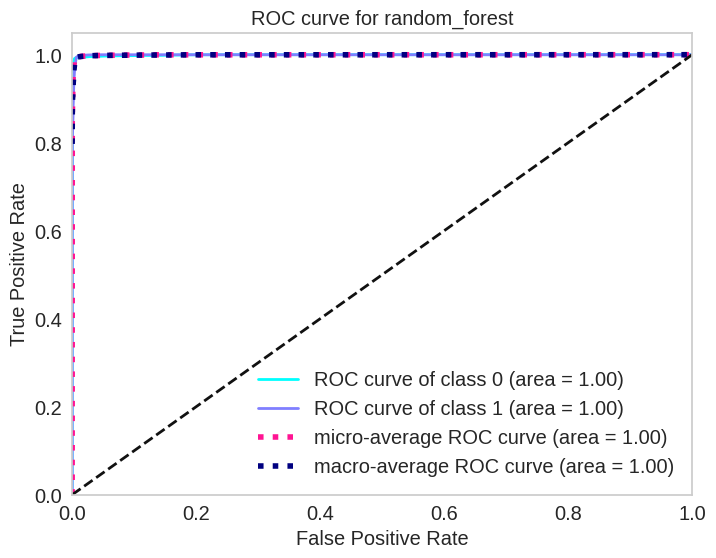

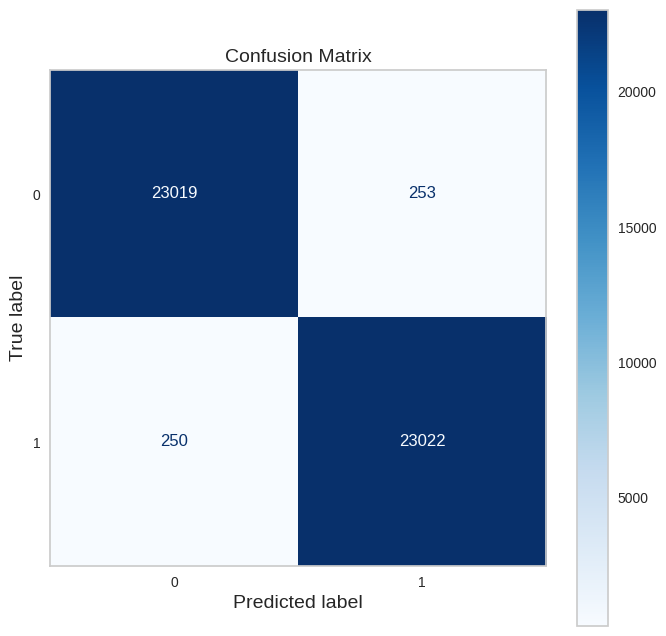

/home/minh48xh/anaconda3/envs/credit/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


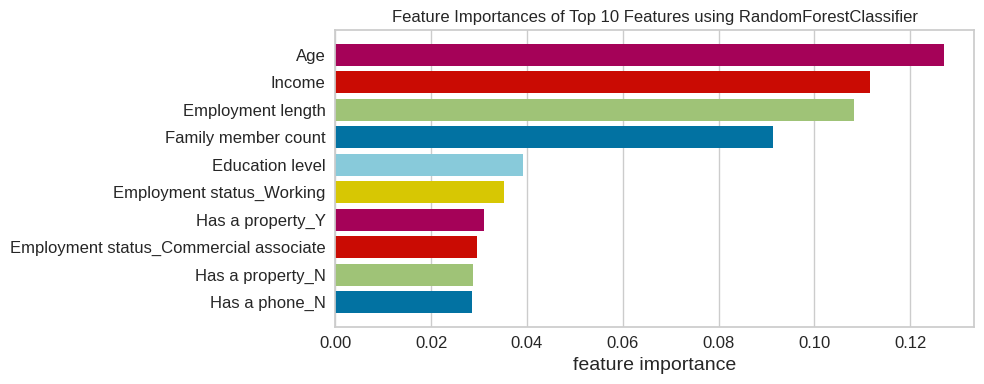

/home/minh48xh/anaconda3/envs/credit/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


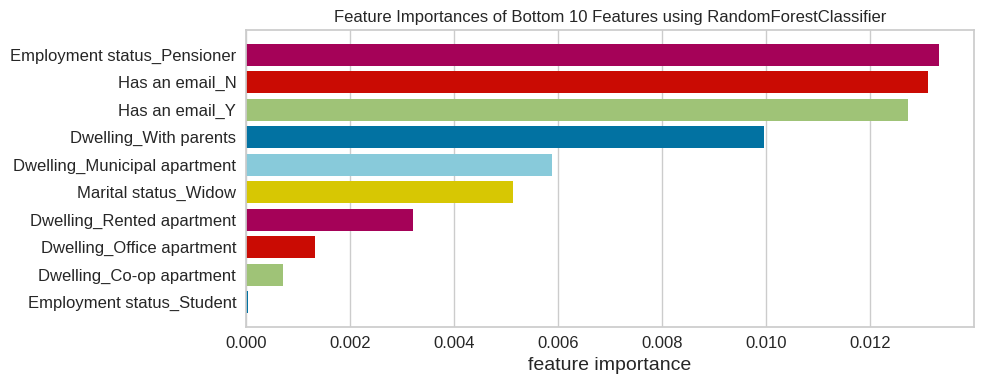

In [127]:
# loop over all the models
for model_name,model in classifiers.items():
    # title formatting
    print('\n')
    print('\n')
    print('  {}  '.center(50,'-').format(model_name))
    print('\n')
    # check if the folder for saving the model exists, if not create it
    folder_check_model()
    # train the model
    model_trn = train_model(model,model_name)
    # print the scores from the classification report
    score_func(model_trn, model_name)
    # plot the ROC curve
    roc_curve_func(model_trn,model_name)
    # plot the confusion matrix
    confusion_matrix_func(model_trn,model_name)
    # plot feature importance
    feat_importance_plot(model_trn, model_name)
    warnings.filterwarnings("ignore")
